In this notebook, we extract significantly spatially varying genes and show them in three clusters.

Load relevant packages, including SpatialDE:

In [1]:
import sys,os
path = '/nfs/team283/aa16/InSituCellTools/'
os.chdir(path)
sys.path.append(path)

In [2]:
%pylab inline
import pandas as pd
import NaiveDE
import SpatialDE
import statsmodels.stats.multitest as multi
import scipy.stats as ss
import pickle as pickle
import scipy as sc
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Populating the interactive namespace from numpy and matplotlib


Load the data and remove negative probes for this analysis:

In [3]:
adata = pickle.load(open('../KR_NAS/data/nanostringWTA_fetailBrain_AnnData.p',  "rb"))
adata = adata[:,adata.var_names != 'NegProbe-WTX']

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


Choose the data from 19pcw replicates at radial position 2:

In [4]:
subset_19pcw = [adata.obs['Radial_position'][i] == 2 and
                adata.obs['age'][i] == '19pcw' for i in range(np.shape(adata.obs)[0])]

Prepare data for spatialDE using both normal and corrected counts:

In [5]:
adata.layers['Stabilized'] = NaiveDE.stabilize(adata.X)
adata.obs['TotalCounts'] = np.sum(adata.X, axis = 1)

adata.layers['TotalCountsRegressed'] = NaiveDE.regress_out(adata.obs, adata.layers['Stabilized'].T, 'np.log(TotalCounts)').T

input_data = pd.DataFrame(adata.layers['TotalCountsRegressed'][subset_19pcw,:], index = adata.obs['Sanger_sampleID'][subset_19pcw],
                   columns = adata.var_names)

In [6]:
adata.layers['Stabilized_corrected'] = NaiveDE.stabilize(adata.layers['X_Corrected_V2'])
adata.obs['TotalCounts_corrected'] = np.sum(adata.layers['X_Corrected_V2'], axis = 1)

adata.layers['TotalCountsRegressed_corrected'] = NaiveDE.regress_out(adata.obs, adata.layers['Stabilized_corrected'].T, 'np.log(TotalCounts_corrected)').T

input_data_corrected = pd.DataFrame(adata.layers['TotalCountsRegressed_corrected'][subset_19pcw,:], index = adata.obs['Sanger_sampleID'][subset_19pcw],
                   columns = adata.var_names)

In [7]:
input_coordinates = adata.obs.loc[subset_19pcw,('Radial_position', 'VCDepth')].rename(columns={"Radial_position": "x", "VCDepth": "y"})

In [8]:
adata.layers['CPM'] = np.asarray([adata.X[i,:]/adata.obs['TotalCounts'][i] for i in range(len(adata.obs['TotalCounts']))])*10**6
adata.layers['zscore_19pcw'] = sc.stats.zscore(np.log2(adata.layers['CPM']+1), axis = 0)

In [9]:
adata.layers['CPM_corrected'] = np.asarray([adata.layers['X_Corrected_V2'][i,:]/adata.obs['TotalCounts_corrected'][i] for i in range(len(adata.obs['TotalCounts_corrected']))])*10**6
adata.layers['zscore_19pcw_corrected'] = sc.stats.zscore(np.log2(adata.layers['CPM_corrected']+1), axis = 0)
adata.layers['zscore_19pcw_corrected'][subset_19pcw,:] = sc.stats.zscore(np.log2(adata.layers['CPM_corrected'][subset_19pcw,:]+1), axis = 0)

#adata.layers['Normalized_19pcw_corrected'] = [adata.layers['X_Corrected'].iloc[:,i]]

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [10]:
input_data

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
Sanger_sampleID,,,,,,,,,,,,,,,,,,,,,
HCA_F_BRA8739178,-14.233437,-13.323642,-9.171705,-11.594233,-13.723814,-13.925083,-13.388883,-10.221606,-11.977764,-13.332700,...,-12.811270,-8.426424,-14.320766,-10.842672,-8.222341,-13.110542,-10.863919,-8.405657,-11.154213,-11.144653
HCA_F_BRA8739185,-14.247205,-13.110711,-10.235329,-11.902695,-13.980560,-14.036259,-13.588997,-10.214799,-12.070953,-13.464384,...,-12.645786,-8.177202,-14.373078,-10.721557,-8.203825,-13.316921,-11.011270,-7.923384,-11.053098,-10.863922
HCA_F_BRA8739186,-14.613198,-13.424265,-9.367901,-12.302788,-13.867446,-14.252996,-13.669512,-10.423172,-11.986166,-13.711046,...,-12.936405,-8.511142,-14.586959,-10.832327,-8.236569,-13.489468,-10.617087,-8.463390,-11.306222,-11.101430
HCA_F_BRA8739193,-14.588518,-13.247858,-9.660022,-11.809081,-13.850013,-14.245904,-13.684855,-10.338036,-12.272410,-13.530771,...,-12.704438,-8.314862,-14.503888,-10.739537,-7.970089,-13.061608,-10.940994,-8.508403,-11.239439,-11.149542
HCA_F_BRA8739194,-14.912922,-13.450720,-10.197381,-12.104558,-14.158435,-14.533563,-13.867798,-10.649741,-12.023074,-13.712052,...,-12.917033,-8.624993,-14.794425,-10.843777,-8.193542,-13.606772,-10.755516,-8.327227,-11.269907,-11.310201
HCA_F_BRA8739201,-14.545019,-13.309674,-9.380480,-12.010783,-13.924904,-14.158711,-13.569113,-10.190870,-12.072181,-13.486893,...,-12.973176,-8.250168,-14.462567,-10.823659,-7.959009,-13.361638,-10.951876,-8.717733,-11.235622,-11.082763
HCA_F_BRA8739202,-14.919498,-13.826266,-10.253319,-12.227372,-14.284755,-14.683197,-13.923012,-10.471782,-12.146438,-13.847281,...,-13.054744,-8.857048,-14.919949,-10.827734,-8.236057,-13.709222,-10.740440,-8.085034,-11.435391,-11.216259
HCA_F_BRA8739209,-14.585436,-13.149958,-9.436646,-11.647925,-13.672596,-14.134252,-13.814857,-10.156263,-12.015662,-13.316882,...,-12.836215,-8.036760,-14.295639,-10.802506,-7.977872,-13.133286,-11.010653,-8.679535,-11.235220,-11.130129
HCA_F_BRA8739210,-15.066659,-13.768358,-10.276834,-12.314117,-14.327915,-14.697667,-14.088697,-10.535308,-12.018484,-13.743253,...,-13.006842,-8.799363,-14.938629,-10.679056,-8.178426,-13.696437,-10.724439,-7.886944,-11.253537,-11.311294


Run spatialDE:

In [11]:
results = SpatialDE.run(input_coordinates, input_data)

In [12]:
results_corrected = SpatialDE.run(input_coordinates, input_data_corrected)

Get list of all spatially varying genes:

In [13]:
threshold = 0.05
print('significance threshold (fdr/qval):', threshold)
results = results.sort_values('qval')
genes_ranked = np.array(results['g'])
genes_significant_fdr = genes_ranked[multi.multipletests(results['pval'], method = 'fdr_bh')[1] < threshold]
genes_significant_qval = genes_ranked[results['qval'] < 0.05]
print('genes significant (fdr):', len(genes_significant_fdr))
print('genes significant (qval):', len(genes_significant_qval))
overlap = sum([genes_significant_fdr[i] in genes_significant_qval for i in range(len(genes_significant_fdr))])/len(genes_significant_fdr)
print('overlap_fdr_qval:', overlap)
percent_significant_fdr = len(genes_significant_fdr)/len(genes_ranked)
percent_significant_qval = len(genes_significant_qval)/len(genes_ranked)
print('percent_significant_fdr:', percent_significant_fdr)
print('percent_significant_qval:', percent_significant_qval)

significance threshold (fdr/qval): 0.05
genes significant (fdr): 7466
genes significant (qval): 15409
overlap_fdr_qval: 1.0
percent_significant_fdr: 0.4084468515783139
percent_significant_qval: 0.8429892226051754


In [14]:
threshold = 0.05
print('significance threshold (fdr/qval):', threshold)
results = results.sort_values('qval')
genes_ranked = np.array(results_corrected['g'])
genes_significant_fdr = genes_ranked[multi.multipletests(results_corrected['pval'], method = 'fdr_bh')[1] < threshold]
genes_significant_qval = genes_ranked[results_corrected['qval'] < 0.05]
print('genes significant (fdr):', len(genes_significant_fdr))
print('genes significant (qval):', len(genes_significant_qval))
overlap = sum([genes_significant_fdr[i] in genes_significant_qval for i in range(len(genes_significant_fdr))])/len(genes_significant_fdr)
print('overlap_fdr_qval:', overlap)
percent_significant_fdr = len(genes_significant_fdr)/len(genes_ranked)
percent_significant_qval = len(genes_significant_qval)/len(genes_ranked)
print('percent_significant_fdr:', percent_significant_fdr)
print('percent_significant_qval:', percent_significant_qval)

significance threshold (fdr/qval): 0.05
genes significant (fdr): 2285
genes significant (qval): 4303
overlap_fdr_qval: 1.0
percent_significant_fdr: 0.1250068384484928
percent_significant_qval: 0.2354067509163521


Cluster genes (based on corrected data only):

In [15]:
# 0.1 is acceptable
n_patterns = 10
results_patterns = SpatialDE.aeh.spatial_patterns(input_coordinates, input_data_corrected, results_corrected.loc[results_corrected['qval'] < 0.05,:], C=n_patterns, l=1, verbosity=1, maxiter= 1000)

iter 0, ELBO: -9.78e+09
iter 1, ELBO: -4.97e+09, delta_ELBO: 4.81e+09
iter 2, ELBO: -4.97e+09, delta_ELBO: 1.83e+04
iter 3, ELBO: -4.97e+09, delta_ELBO: 3.28e+04
iter 4, ELBO: -4.97e+09, delta_ELBO: 1.17e+04
iter 5, ELBO: -4.97e+09, delta_ELBO: 3.77e+03
iter 6, ELBO: -4.97e+09, delta_ELBO: 3.05e+03
iter 7, ELBO: -4.97e+09, delta_ELBO: 1.93e+03
iter 8, ELBO: -4.97e+09, delta_ELBO: 8.28e+02
iter 9, ELBO: -4.97e+09, delta_ELBO: 3.60e+02
iter 10, ELBO: -4.97e+09, delta_ELBO: 2.03e+02
iter 11, ELBO: -4.97e+09, delta_ELBO: 1.44e+02
iter 12, ELBO: -4.97e+09, delta_ELBO: 1.19e+02
iter 13, ELBO: -4.97e+09, delta_ELBO: 1.05e+02
iter 14, ELBO: -4.97e+09, delta_ELBO: 9.34e+01
iter 15, ELBO: -4.97e+09, delta_ELBO: 8.33e+01
iter 16, ELBO: -4.97e+09, delta_ELBO: 7.36e+01
iter 17, ELBO: -4.97e+09, delta_ELBO: 6.45e+01
iter 18, ELBO: -4.97e+09, delta_ELBO: 5.60e+01
iter 19, ELBO: -4.97e+09, delta_ELBO: 4.84e+01
iter 20, ELBO: -4.97e+09, delta_ELBO: 4.19e+01
iter 21, ELBO: -4.97e+09, delta_ELBO: 3.63e+0

Plot patterns and include marker genes using z-score, normed counts and cpm:

In [16]:
pat_genes = list()
for i in range(n_patterns):
    pat1_subset = np.array(results_patterns[0]['pattern'] == i)
    pat_genes.append(results_patterns[0].iloc[pat1_subset].iloc[np.argsort(-results_patterns[0]['membership'].iloc[pat1_subset])])

colourCode = pickle.load(open('../KR_NAS/0_publication_figures_scripts/celltypesColourCode.p',  "rb"))
colourCode

l = list(colourCode.loc[:,'Markers'])
marker_genes = np.unique([item for sublist in l for item in sublist])

colourPalette = pd.DataFrame(index = marker_genes, columns = ['Colour'])
for i in range(len(marker_genes)):
    for j in range(np.shape(colourCode)[0]-1,-1,-1):
        if marker_genes[i] in colourCode.loc[:,'Markers'].iloc[j]:
            colourPalette.iloc[i,0] = colourCode.iloc[j,2]
colourPalette

pat_markers = list()
for j in range(n_patterns):
    pat_markers.append(marker_genes[[marker_genes[i] in np.array(pat_genes[j]['g']) for i in range(len(marker_genes))]])
n_topGenes = 100
n_markerGenes = 4
polynomial_order = 5

In [17]:
pat_markers = list()
for j in range(n_patterns):
    pat_markers.append(marker_genes[[marker_genes[i] in np.array(pat_genes[j]['g']) for i in range(len(marker_genes))]])
n_topGenes = 70
n_markerGenes = 4
polynomial_order = 5

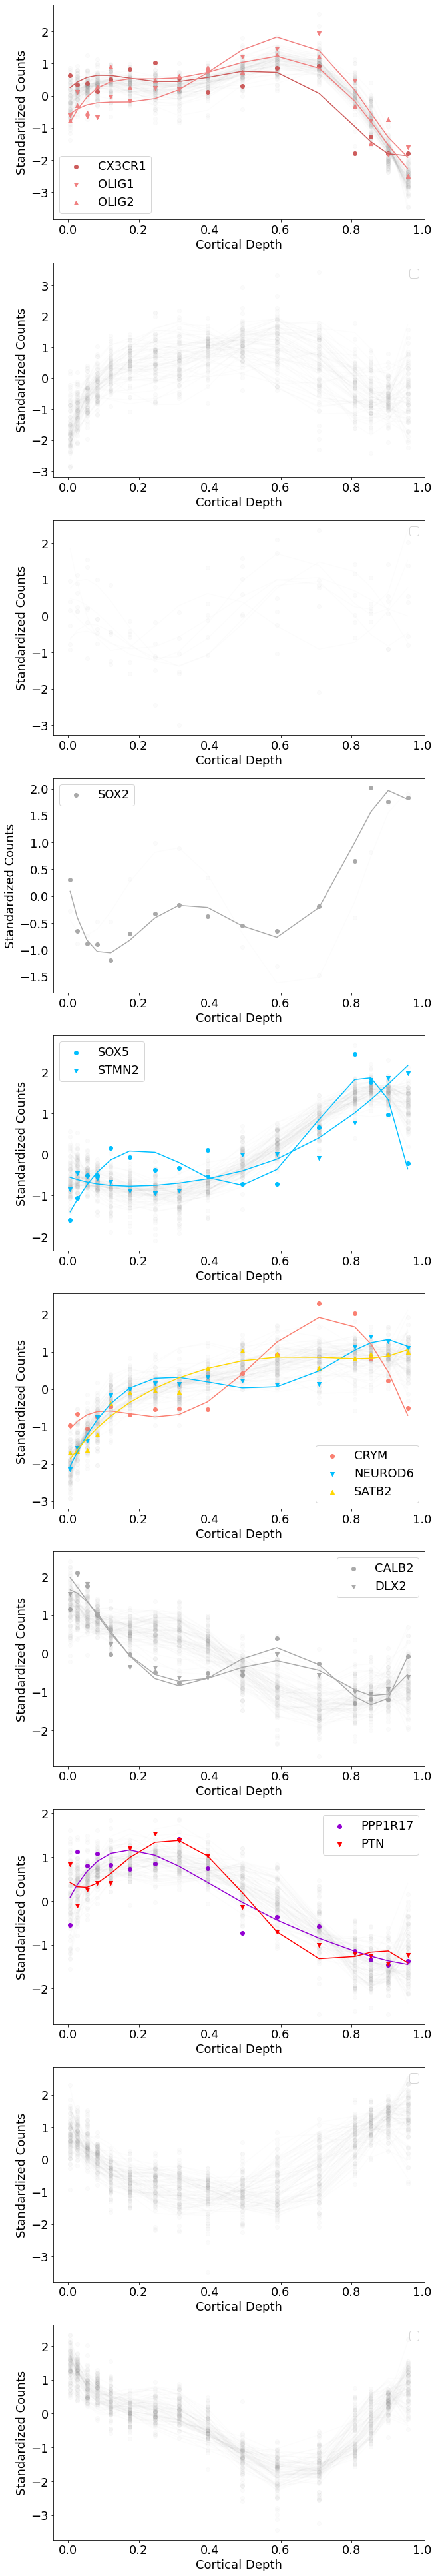

In [18]:
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

c_palette = ('blue', 'red', 'green', 'yellow')

fig, ax = plt.subplots(n_patterns,1,figsize=(10, n_patterns*7))

for i in range(n_patterns):

    for j in range(np.min([n_topGenes,len(pat_genes[i]['g'])])):
        ax[i].scatter(adata.obs['VCDepth'][subset_19pcw],
                adata.layers['zscore_19pcw_corrected'][subset_19pcw, np.where(adata.var_names == pat_genes[i]['g'].iloc[j])[0][0]],
                c = 'grey', alpha = 0.033)
        x = adata.obs['VCDepth'][subset_19pcw]
        y = adata.layers['zscore_19pcw_corrected'][subset_19pcw, np.where(adata.var_names == pat_genes[i]['g'].iloc[j])[0][0]]
        ax[i].plot(np.unique(x), np.poly1d(np.polyfit(x, y, polynomial_order))(np.unique(x)),
                   c = 'grey', alpha = 0.02)

    marker_styles = ("o", "v", "^", "s")
    for k in range(n_markerGenes):
        if len(pat_markers[i]) > k:
            colour = list(colourPalette.loc[pat_markers[i][k],:])[0]
            ax[i].scatter(adata.obs['VCDepth'][subset_19pcw],
                        adata.layers['zscore_19pcw_corrected'][subset_19pcw, np.where(adata.var_names == pat_markers[i][k])[0][0]],
                       label = pat_markers[i][k],
                          c = colour, marker = marker_styles[k])
            x = adata.obs['VCDepth'][subset_19pcw] 
            y = adata.layers['zscore_19pcw_corrected'][subset_19pcw, np.where(adata.var_names == pat_markers[i][k])[0][0]]
            ax[i].plot(np.unique(x), np.poly1d(np.polyfit(x, y, polynomial_order))(np.unique(x)),
                       c = colour)

    ax[i].set_xlabel('Cortical Depth')
    ax[i].set_ylabel('Standardized Counts')
    ax[i].legend()
# plt.savefig('../KR_NAS/0_publication_figures/Figure2_SpatialDE_' + str(n_patterns) + 'patterns_zscore_parameters' + str(m)
#                 + '_' + str(n) + '.pdf')

Get number of genes in each pattern:

In [87]:
pattern_genes_num = [sum(results_patterns[0]['pattern'] == p) for p in range(10)]
pattern_genes_num

[8022, 504, 190, 490, 328, 729, 391, 1008, 403, 736]

Run through all parameter settings:

In [79]:
dataArray = (input_data, input_data_corrected)
lArray = (0.01,0.02,0.05,0.075,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.25,1.5,2)

m = 1

for n in range(len(lArray)):
    for n_patterns in np.array((5,8,10,12,15)):
        print(m)
        print(n)
        print(n_patterns)

        results_patterns = SpatialDE.aeh.spatial_patterns(input_coordinates, dataArray[m],
                                                          results_corrected.loc[results_corrected['qval'] < 0.05,:],
                                                          C=n_patterns, l=lArray[n], verbosity=1, maxiter= 1000)

        pat_genes = list()
        for i in range(n_patterns):
            pat1_subset = np.array(results_patterns[0]['pattern'] == i)
            pat_genes.append(results_patterns[0].iloc[pat1_subset].iloc[np.argsort(-results_patterns[0]['membership'].iloc[pat1_subset])])

        colourCode = pickle.load(open('../KR_NAS/0_publication_figures_scripts/celltypesColourCode.p',  "rb"))
        colourCode

        l = list(colourCode.loc[:,'Markers'])
        marker_genes = np.unique([item for sublist in l for item in sublist])

        colourPalette = pd.DataFrame(index = marker_genes, columns = ['Colour'])
        for i in range(len(marker_genes)):
            for j in range(np.shape(colourCode)[0]-1,-1,-1):
                if marker_genes[i] in colourCode.loc[:,'Markers'].iloc[j]:
                    colourPalette.iloc[i,0] = colourCode.iloc[j,2]
        colourPalette

        pat_markers = list()
        for j in range(n_patterns):
            pat_markers.append(marker_genes[[marker_genes[i] in np.array(pat_genes[j]['g']) for i in range(len(marker_genes))]])
        n_topGenes = 100
        n_markerGenes = 4
        polynomial_order = 5

        marker_genes = marker_genes[marker_genes != 'SOX2']

        pat_markers = list()
        for j in range(n_patterns):
            pat_markers.append(marker_genes[[marker_genes[i] in np.array(pat_genes[j]['g']) for i in range(len(marker_genes))]])
        n_topGenes = 70
        n_markerGenes = 4
        polynomial_order = 5

        SMALL_SIZE = 18
        MEDIUM_SIZE = 18
        BIGGER_SIZE = 18

        plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
        plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
        plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

        c_palette = ('blue', 'red', 'green', 'yellow')

        fig, ax = plt.subplots(n_patterns,1,figsize=(10, n_patterns*7))

        for i in range(n_patterns):

            for j in range(np.min([n_topGenes,len(pat_genes[i]['g'])])):
                ax[i].scatter(adata.obs['VCDepth'][subset_19pcw],
                        adata.layers['zscore_19pcw_corrected'][subset_19pcw, np.where(adata.var_names == pat_genes[i]['g'].iloc[j])[0][0]],
                        c = 'grey', alpha = 0.033)
                x = adata.obs['VCDepth'][subset_19pcw]
                y = adata.layers['zscore_19pcw_corrected'][subset_19pcw, np.where(adata.var_names == pat_genes[i]['g'].iloc[j])[0][0]]
                ax[i].plot(np.unique(x), np.poly1d(np.polyfit(x, y, polynomial_order))(np.unique(x)),
                           c = 'grey', alpha = 0.02)

            marker_styles = ("o", "v", "^", "s")
            for k in range(n_markerGenes):
                if len(pat_markers[i]) > k:
                    colour = list(colourPalette.loc[pat_markers[i][k],:])[0]
                    ax[i].scatter(adata.obs['VCDepth'][subset_19pcw],
                                adata.layers['zscore_19pcw_corrected'][subset_19pcw, np.where(adata.var_names == pat_markers[i][k])[0][0]],
                               label = pat_markers[i][k],
                                  c = colour, marker = marker_styles[k])
                    x = adata.obs['VCDepth'][subset_19pcw] 
                    y = adata.layers['zscore_19pcw_corrected'][subset_19pcw, np.where(adata.var_names == pat_markers[i][k])[0][0]]
                    ax[i].plot(np.unique(x), np.poly1d(np.polyfit(x, y, polynomial_order))(np.unique(x)),
                               c = colour)

            ax[i].set_xlabel('Cortical Depth')
            ax[i].set_ylabel('Standardized Counts')
            ax[i].legend()
        plt.savefig('../KR_NAS/0_publication_figures/Figure2_SpatialDE_' + str(n_patterns) + 'patterns_zscore_parameters' + str(m)
                        + '_' + str(n) + '.pdf')

1
0
5
iter 0, ELBO: -1.55e+04
iter 1, ELBO: -6.86e+05, delta_ELBO: 6.70e+05
iter 2, ELBO: -7.76e+05, delta_ELBO: 9.01e+04
iter 3, ELBO: -8.57e+05, delta_ELBO: 8.16e+04
iter 4, ELBO: -8.76e+05, delta_ELBO: 1.81e+04
iter 5, ELBO: -8.80e+05, delta_ELBO: 4.27e+03
iter 6, ELBO: -8.82e+05, delta_ELBO: 2.32e+03
iter 7, ELBO: -8.84e+05, delta_ELBO: 2.36e+03
iter 8, ELBO: -8.86e+05, delta_ELBO: 1.35e+03
iter 9, ELBO: -8.87e+05, delta_ELBO: 7.36e+02
iter 10, ELBO: -8.87e+05, delta_ELBO: 4.40e+02
iter 11, ELBO: -8.87e+05, delta_ELBO: 2.32e+02
iter 12, ELBO: -8.87e+05, delta_ELBO: 7.07e+01
iter 13, ELBO: -8.87e+05, delta_ELBO: 1.65e+01
iter 14, ELBO: -8.87e+05, delta_ELBO: 1.44e+01
iter 15, ELBO: -8.87e+05, delta_ELBO: 2.35e+01
iter 16, ELBO: -8.87e+05, delta_ELBO: 3.06e+01
iter 17, ELBO: -8.87e+05, delta_ELBO: 3.45e+01
iter 18, ELBO: -8.87e+05, delta_ELBO: 3.65e+01
iter 19, ELBO: -8.88e+05, delta_ELBO: 3.76e+01
iter 20, ELBO: -8.88e+05, delta_ELBO: 3.84e+01
iter 21, ELBO: -8.88e+05, delta_ELBO: 3

iter 174, ELBO: -8.89e+05, delta_ELBO: 2.10e-02
iter 175, ELBO: -8.89e+05, delta_ELBO: 3.61e-02
iter 176, ELBO: -8.89e+05, delta_ELBO: 2.39e-02
iter 177, ELBO: -8.89e+05, delta_ELBO: 3.36e-02
iter 178, ELBO: -8.89e+05, delta_ELBO: 1.05e-02
iter 179, ELBO: -8.89e+05, delta_ELBO: 3.12e-02
iter 180, ELBO: -8.89e+05, delta_ELBO: 1.94e-02
iter 181, ELBO: -8.89e+05, delta_ELBO: 1.27e-02
iter 182, ELBO: -8.89e+05, delta_ELBO: 2.28e-02
iter 183, ELBO: -8.89e+05, delta_ELBO: 1.31e-04
Converged on iter 183
1
0
8
iter 0, ELBO: -2.52e+04
iter 1, ELBO: -7.01e+05, delta_ELBO: 6.76e+05
iter 2, ELBO: -8.04e+05, delta_ELBO: 1.03e+05
iter 3, ELBO: -8.83e+05, delta_ELBO: 7.97e+04
iter 4, ELBO: -9.02e+05, delta_ELBO: 1.91e+04
iter 5, ELBO: -9.13e+05, delta_ELBO: 1.01e+04
iter 6, ELBO: -9.19e+05, delta_ELBO: 6.69e+03
iter 7, ELBO: -9.26e+05, delta_ELBO: 6.63e+03
iter 8, ELBO: -9.30e+05, delta_ELBO: 4.33e+03
iter 9, ELBO: -9.32e+05, delta_ELBO: 1.88e+03
iter 10, ELBO: -9.33e+05, delta_ELBO: 7.17e+02
iter 11

1
0
10
iter 0, ELBO: -2.50e+04
iter 1, ELBO: -7.09e+05, delta_ELBO: 6.84e+05
iter 2, ELBO: -7.93e+05, delta_ELBO: 8.38e+04
iter 3, ELBO: -8.99e+05, delta_ELBO: 1.06e+05
iter 4, ELBO: -9.36e+05, delta_ELBO: 3.72e+04
iter 5, ELBO: -9.50e+05, delta_ELBO: 1.43e+04
iter 6, ELBO: -9.57e+05, delta_ELBO: 6.44e+03
iter 7, ELBO: -9.59e+05, delta_ELBO: 2.44e+03
iter 8, ELBO: -9.60e+05, delta_ELBO: 9.38e+02
iter 9, ELBO: -9.61e+05, delta_ELBO: 4.94e+02
iter 10, ELBO: -9.61e+05, delta_ELBO: 3.52e+02
iter 11, ELBO: -9.61e+05, delta_ELBO: 3.56e+02
iter 12, ELBO: -9.62e+05, delta_ELBO: 4.32e+02
iter 13, ELBO: -9.62e+05, delta_ELBO: 5.48e+02
iter 14, ELBO: -9.63e+05, delta_ELBO: 6.07e+02
iter 15, ELBO: -9.64e+05, delta_ELBO: 5.50e+02
iter 16, ELBO: -9.64e+05, delta_ELBO: 4.48e+02
iter 17, ELBO: -9.64e+05, delta_ELBO: 3.31e+02
iter 18, ELBO: -9.65e+05, delta_ELBO: 2.27e+02
iter 19, ELBO: -9.65e+05, delta_ELBO: 1.38e+02
iter 20, ELBO: -9.65e+05, delta_ELBO: 9.99e+01
iter 21, ELBO: -9.65e+05, delta_ELBO: 

1
0
12
iter 0, ELBO: -4.13e+04
iter 1, ELBO: -7.11e+05, delta_ELBO: 6.70e+05
iter 2, ELBO: -8.05e+05, delta_ELBO: 9.42e+04
iter 3, ELBO: -9.04e+05, delta_ELBO: 9.90e+04
iter 4, ELBO: -9.35e+05, delta_ELBO: 3.12e+04
iter 5, ELBO: -9.49e+05, delta_ELBO: 1.42e+04
iter 6, ELBO: -9.58e+05, delta_ELBO: 8.33e+03
iter 7, ELBO: -9.64e+05, delta_ELBO: 5.90e+03
iter 8, ELBO: -9.68e+05, delta_ELBO: 4.09e+03
iter 9, ELBO: -9.71e+05, delta_ELBO: 2.69e+03
iter 10, ELBO: -9.72e+05, delta_ELBO: 1.96e+03
iter 11, ELBO: -9.74e+05, delta_ELBO: 1.44e+03
iter 12, ELBO: -9.75e+05, delta_ELBO: 9.19e+02
iter 13, ELBO: -9.75e+05, delta_ELBO: 4.82e+02
iter 14, ELBO: -9.76e+05, delta_ELBO: 2.63e+02
iter 15, ELBO: -9.76e+05, delta_ELBO: 1.88e+02
iter 16, ELBO: -9.76e+05, delta_ELBO: 1.57e+02
iter 17, ELBO: -9.76e+05, delta_ELBO: 1.40e+02
iter 18, ELBO: -9.76e+05, delta_ELBO: 1.31e+02
iter 19, ELBO: -9.76e+05, delta_ELBO: 1.22e+02
iter 20, ELBO: -9.76e+05, delta_ELBO: 1.11e+02
iter 21, ELBO: -9.77e+05, delta_ELBO: 

1
0
15
iter 0, ELBO: -3.89e+04
iter 1, ELBO: -7.18e+05, delta_ELBO: 6.79e+05
iter 2, ELBO: -8.00e+05, delta_ELBO: 8.23e+04
iter 3, ELBO: -9.25e+05, delta_ELBO: 1.24e+05
iter 4, ELBO: -9.70e+05, delta_ELBO: 4.52e+04
iter 5, ELBO: -9.87e+05, delta_ELBO: 1.74e+04
iter 6, ELBO: -9.96e+05, delta_ELBO: 8.54e+03
iter 7, ELBO: -1.00e+06, delta_ELBO: 5.31e+03
iter 8, ELBO: -1.00e+06, delta_ELBO: 3.45e+03
iter 9, ELBO: -1.01e+06, delta_ELBO: 2.09e+03
iter 10, ELBO: -1.01e+06, delta_ELBO: 1.44e+03
iter 11, ELBO: -1.01e+06, delta_ELBO: 9.74e+02
iter 12, ELBO: -1.01e+06, delta_ELBO: 7.72e+02
iter 13, ELBO: -1.01e+06, delta_ELBO: 7.05e+02
iter 14, ELBO: -1.01e+06, delta_ELBO: 5.63e+02
iter 15, ELBO: -1.01e+06, delta_ELBO: 4.02e+02
iter 16, ELBO: -1.01e+06, delta_ELBO: 3.28e+02
iter 17, ELBO: -1.01e+06, delta_ELBO: 2.71e+02
iter 18, ELBO: -1.01e+06, delta_ELBO: 2.17e+02
iter 19, ELBO: -1.01e+06, delta_ELBO: 1.69e+02
iter 20, ELBO: -1.01e+06, delta_ELBO: 1.35e+02
iter 21, ELBO: -1.01e+06, delta_ELBO: 

1
1
5
iter 0, ELBO: -3.60e+05
iter 1, ELBO: -9.40e+05, delta_ELBO: 5.80e+05
iter 2, ELBO: -1.05e+06, delta_ELBO: 1.07e+05
iter 3, ELBO: -1.10e+06, delta_ELBO: 4.96e+04
iter 4, ELBO: -1.12e+06, delta_ELBO: 2.64e+04
iter 5, ELBO: -1.13e+06, delta_ELBO: 3.60e+03
iter 6, ELBO: -1.13e+06, delta_ELBO: 1.18e+03
iter 7, ELBO: -1.13e+06, delta_ELBO: 6.84e+02
iter 8, ELBO: -1.13e+06, delta_ELBO: 5.99e+02
iter 9, ELBO: -1.13e+06, delta_ELBO: 6.05e+02
iter 10, ELBO: -1.13e+06, delta_ELBO: 6.84e+02
iter 11, ELBO: -1.13e+06, delta_ELBO: 8.24e+02
iter 12, ELBO: -1.13e+06, delta_ELBO: 1.00e+03
iter 13, ELBO: -1.13e+06, delta_ELBO: 1.17e+03
iter 14, ELBO: -1.13e+06, delta_ELBO: 1.32e+03
iter 15, ELBO: -1.14e+06, delta_ELBO: 1.38e+03
iter 16, ELBO: -1.14e+06, delta_ELBO: 1.34e+03
iter 17, ELBO: -1.14e+06, delta_ELBO: 1.16e+03
iter 18, ELBO: -1.14e+06, delta_ELBO: 8.90e+02
iter 19, ELBO: -1.14e+06, delta_ELBO: 1.88e+02
iter 20, ELBO: -1.14e+06, delta_ELBO: 1.02e+02
iter 21, ELBO: -1.14e+06, delta_ELBO: 2

iter 82, ELBO: -1.34e+06, delta_ELBO: 9.46e-02
iter 83, ELBO: -1.34e+06, delta_ELBO: 8.29e-02
iter 84, ELBO: -1.34e+06, delta_ELBO: 7.35e-02
iter 85, ELBO: -1.34e+06, delta_ELBO: 8.46e-02
iter 86, ELBO: -1.34e+06, delta_ELBO: 6.77e-02
iter 87, ELBO: -1.34e+06, delta_ELBO: 5.62e-02
iter 88, ELBO: -1.34e+06, delta_ELBO: 1.01e-01
iter 89, ELBO: -1.34e+06, delta_ELBO: 5.89e-02
iter 90, ELBO: -1.34e+06, delta_ELBO: 5.76e-02
iter 91, ELBO: -1.34e+06, delta_ELBO: 7.86e-02
iter 92, ELBO: -1.34e+06, delta_ELBO: 5.18e-02
iter 93, ELBO: -1.34e+06, delta_ELBO: 2.27e-02
iter 94, ELBO: -1.34e+06, delta_ELBO: 5.59e-02
iter 95, ELBO: -1.34e+06, delta_ELBO: 9.01e-02
iter 96, ELBO: -1.34e+06, delta_ELBO: 5.31e-02
iter 97, ELBO: -1.34e+06, delta_ELBO: 5.96e-02
iter 98, ELBO: -1.34e+06, delta_ELBO: 1.18e-02
iter 99, ELBO: -1.34e+06, delta_ELBO: 7.52e-02
iter 100, ELBO: -1.34e+06, delta_ELBO: 3.18e-02
iter 101, ELBO: -1.34e+06, delta_ELBO: 5.11e-02
iter 102, ELBO: -1.34e+06, delta_ELBO: 4.25e-02
iter 103, 

1
1
10
iter 0, ELBO: -9.84e+05
iter 1, ELBO: -1.21e+06, delta_ELBO: 2.23e+05
iter 2, ELBO: -1.28e+06, delta_ELBO: 7.70e+04
iter 3, ELBO: -1.38e+06, delta_ELBO: 9.92e+04
iter 4, ELBO: -1.43e+06, delta_ELBO: 4.50e+04
iter 5, ELBO: -1.45e+06, delta_ELBO: 1.81e+04
iter 6, ELBO: -1.45e+06, delta_ELBO: 3.95e+03
iter 7, ELBO: -1.45e+06, delta_ELBO: 1.87e+03
iter 8, ELBO: -1.45e+06, delta_ELBO: 1.65e+03
iter 9, ELBO: -1.46e+06, delta_ELBO: 2.01e+03
iter 10, ELBO: -1.46e+06, delta_ELBO: 1.81e+03
iter 11, ELBO: -1.46e+06, delta_ELBO: 1.06e+03
iter 12, ELBO: -1.46e+06, delta_ELBO: 8.00e+02
iter 13, ELBO: -1.46e+06, delta_ELBO: 6.73e+02
iter 14, ELBO: -1.46e+06, delta_ELBO: 5.83e+02
iter 15, ELBO: -1.46e+06, delta_ELBO: 4.34e+02
iter 16, ELBO: -1.46e+06, delta_ELBO: 2.58e+02
iter 17, ELBO: -1.46e+06, delta_ELBO: 1.30e+02
iter 18, ELBO: -1.46e+06, delta_ELBO: 6.51e+01
iter 19, ELBO: -1.46e+06, delta_ELBO: 5.59e+01
iter 20, ELBO: -1.46e+06, delta_ELBO: 9.48e+01
iter 21, ELBO: -1.46e+06, delta_ELBO: 

1
1
12
iter 0, ELBO: -1.40e+06
iter 1, ELBO: -1.31e+06, delta_ELBO: 8.34e+04
iter 2, ELBO: -1.39e+06, delta_ELBO: 8.08e+04
iter 3, ELBO: -1.51e+06, delta_ELBO: 1.13e+05
iter 4, ELBO: -1.55e+06, delta_ELBO: 4.32e+04
iter 5, ELBO: -1.56e+06, delta_ELBO: 1.28e+04
iter 6, ELBO: -1.57e+06, delta_ELBO: 5.63e+03
iter 7, ELBO: -1.57e+06, delta_ELBO: 3.76e+03
iter 8, ELBO: -1.57e+06, delta_ELBO: 2.47e+03
iter 9, ELBO: -1.58e+06, delta_ELBO: 1.70e+03
iter 10, ELBO: -1.58e+06, delta_ELBO: 1.30e+03
iter 11, ELBO: -1.58e+06, delta_ELBO: 9.90e+02
iter 12, ELBO: -1.58e+06, delta_ELBO: 7.19e+02
iter 13, ELBO: -1.58e+06, delta_ELBO: 5.48e+02
iter 14, ELBO: -1.58e+06, delta_ELBO: 3.78e+02
iter 15, ELBO: -1.58e+06, delta_ELBO: 2.14e+02
iter 16, ELBO: -1.58e+06, delta_ELBO: 1.07e+02
iter 17, ELBO: -1.58e+06, delta_ELBO: 5.13e+01
iter 18, ELBO: -1.58e+06, delta_ELBO: 2.15e+01
iter 19, ELBO: -1.58e+06, delta_ELBO: 4.13e+00
iter 20, ELBO: -1.58e+06, delta_ELBO: 4.09e+00
iter 21, ELBO: -1.58e+06, delta_ELBO: 

1
1
15
iter 0, ELBO: -1.65e+06
iter 1, ELBO: -1.46e+06, delta_ELBO: 1.90e+05
iter 2, ELBO: -1.55e+06, delta_ELBO: 9.24e+04
iter 3, ELBO: -1.66e+06, delta_ELBO: 1.10e+05
iter 4, ELBO: -1.69e+06, delta_ELBO: 2.84e+04
iter 5, ELBO: -1.71e+06, delta_ELBO: 1.66e+04
iter 6, ELBO: -1.72e+06, delta_ELBO: 1.05e+04
iter 7, ELBO: -1.72e+06, delta_ELBO: 6.68e+03
iter 8, ELBO: -1.73e+06, delta_ELBO: 4.18e+03
iter 9, ELBO: -1.73e+06, delta_ELBO: 2.59e+03
iter 10, ELBO: -1.73e+06, delta_ELBO: 1.84e+03
iter 11, ELBO: -1.73e+06, delta_ELBO: 1.22e+03
iter 12, ELBO: -1.73e+06, delta_ELBO: 1.04e+03
iter 13, ELBO: -1.74e+06, delta_ELBO: 1.11e+03
iter 14, ELBO: -1.74e+06, delta_ELBO: 1.03e+03
iter 15, ELBO: -1.74e+06, delta_ELBO: 9.93e+02
iter 16, ELBO: -1.74e+06, delta_ELBO: 8.87e+02
iter 17, ELBO: -1.74e+06, delta_ELBO: 8.39e+02
iter 18, ELBO: -1.74e+06, delta_ELBO: 8.05e+02
iter 19, ELBO: -1.74e+06, delta_ELBO: 5.93e+02
iter 20, ELBO: -1.74e+06, delta_ELBO: 3.85e+02
iter 21, ELBO: -1.74e+06, delta_ELBO: 

iter 174, ELBO: -1.75e+06, delta_ELBO: 2.53e-01
iter 175, ELBO: -1.75e+06, delta_ELBO: 2.02e-01
iter 176, ELBO: -1.75e+06, delta_ELBO: 2.31e-01
iter 177, ELBO: -1.75e+06, delta_ELBO: 1.56e-01
iter 178, ELBO: -1.75e+06, delta_ELBO: 1.78e-01
iter 179, ELBO: -1.75e+06, delta_ELBO: 1.94e-01
iter 180, ELBO: -1.75e+06, delta_ELBO: 1.76e-01
iter 181, ELBO: -1.75e+06, delta_ELBO: 1.18e-01
iter 182, ELBO: -1.75e+06, delta_ELBO: 1.26e-01
iter 183, ELBO: -1.75e+06, delta_ELBO: 1.28e-01
iter 184, ELBO: -1.75e+06, delta_ELBO: 1.46e-01
iter 185, ELBO: -1.75e+06, delta_ELBO: 8.51e-02
iter 186, ELBO: -1.75e+06, delta_ELBO: 1.30e-01
iter 187, ELBO: -1.75e+06, delta_ELBO: 7.99e-02
iter 188, ELBO: -1.75e+06, delta_ELBO: 1.19e-01
iter 189, ELBO: -1.75e+06, delta_ELBO: 5.67e-02
iter 190, ELBO: -1.75e+06, delta_ELBO: 6.11e-02
iter 191, ELBO: -1.75e+06, delta_ELBO: 7.38e-02
iter 192, ELBO: -1.75e+06, delta_ELBO: 8.70e-02
iter 193, ELBO: -1.75e+06, delta_ELBO: 7.40e-02
iter 194, ELBO: -1.75e+06, delta_ELBO: 3

1
2
5
iter 0, ELBO: -6.53e+08
iter 1, ELBO: -3.33e+08, delta_ELBO: 3.20e+08
iter 2, ELBO: -3.33e+08, delta_ELBO: 9.33e+04
iter 3, ELBO: -3.33e+08, delta_ELBO: 6.91e+04
iter 4, ELBO: -3.33e+08, delta_ELBO: 5.93e+03
iter 5, ELBO: -3.33e+08, delta_ELBO: 2.00e+03
iter 6, ELBO: -3.33e+08, delta_ELBO: 4.38e+03
iter 7, ELBO: -3.33e+08, delta_ELBO: 6.45e+03
iter 8, ELBO: -3.33e+08, delta_ELBO: 3.77e+03
iter 9, ELBO: -3.33e+08, delta_ELBO: 2.05e+03
iter 10, ELBO: -3.33e+08, delta_ELBO: 1.32e+03
iter 11, ELBO: -3.33e+08, delta_ELBO: 8.95e+02
iter 12, ELBO: -3.33e+08, delta_ELBO: 2.55e+02
iter 13, ELBO: -3.33e+08, delta_ELBO: 1.13e+02
iter 14, ELBO: -3.33e+08, delta_ELBO: 2.02e+02
iter 15, ELBO: -3.33e+08, delta_ELBO: 2.05e+02
iter 16, ELBO: -3.33e+08, delta_ELBO: 1.92e+02
iter 17, ELBO: -3.33e+08, delta_ELBO: 1.77e+02
iter 18, ELBO: -3.33e+08, delta_ELBO: 1.65e+02
iter 19, ELBO: -3.33e+08, delta_ELBO: 1.55e+02
iter 20, ELBO: -3.33e+08, delta_ELBO: 1.46e+02
iter 21, ELBO: -3.33e+08, delta_ELBO: 1

1
2
10
iter 0, ELBO: -1.58e+09
iter 1, ELBO: -6.66e+08, delta_ELBO: 9.13e+08
iter 2, ELBO: -6.66e+08, delta_ELBO: 5.73e+04
iter 3, ELBO: -6.66e+08, delta_ELBO: 1.16e+05
iter 4, ELBO: -6.66e+08, delta_ELBO: 2.25e+04
iter 5, ELBO: -6.66e+08, delta_ELBO: 1.06e+04
iter 6, ELBO: -6.66e+08, delta_ELBO: 6.76e+03
iter 7, ELBO: -6.66e+08, delta_ELBO: 5.03e+03
iter 8, ELBO: -6.66e+08, delta_ELBO: 4.30e+03
iter 9, ELBO: -6.66e+08, delta_ELBO: 3.07e+03
iter 10, ELBO: -6.66e+08, delta_ELBO: 1.95e+03
iter 11, ELBO: -6.66e+08, delta_ELBO: 1.45e+03
iter 12, ELBO: -6.66e+08, delta_ELBO: 9.06e+02
iter 13, ELBO: -6.66e+08, delta_ELBO: 6.00e+02
iter 14, ELBO: -6.66e+08, delta_ELBO: 4.57e+02
iter 15, ELBO: -6.66e+08, delta_ELBO: 3.73e+02
iter 16, ELBO: -6.66e+08, delta_ELBO: 2.69e+02
iter 17, ELBO: -6.66e+08, delta_ELBO: 1.51e+02
iter 18, ELBO: -6.66e+08, delta_ELBO: 8.53e+01
iter 19, ELBO: -6.66e+08, delta_ELBO: 5.38e+01
iter 20, ELBO: -6.66e+08, delta_ELBO: 3.69e+01
iter 21, ELBO: -6.66e+08, delta_ELBO: 

1
2
15
iter 0, ELBO: -2.20e+09
iter 1, ELBO: -9.98e+08, delta_ELBO: 1.20e+09
iter 2, ELBO: -9.98e+08, delta_ELBO: 6.64e+04
iter 3, ELBO: -9.98e+08, delta_ELBO: 1.22e+05
iter 4, ELBO: -9.98e+08, delta_ELBO: 3.96e+04
iter 5, ELBO: -9.98e+08, delta_ELBO: 1.21e+04
iter 6, ELBO: -9.98e+08, delta_ELBO: 6.24e+03
iter 7, ELBO: -9.98e+08, delta_ELBO: 3.93e+03
iter 8, ELBO: -9.98e+08, delta_ELBO: 2.46e+03
iter 9, ELBO: -9.98e+08, delta_ELBO: 1.48e+03
iter 10, ELBO: -9.98e+08, delta_ELBO: 8.58e+02
iter 11, ELBO: -9.98e+08, delta_ELBO: 5.56e+02
iter 12, ELBO: -9.98e+08, delta_ELBO: 3.98e+02
iter 13, ELBO: -9.98e+08, delta_ELBO: 3.02e+02
iter 14, ELBO: -9.98e+08, delta_ELBO: 2.45e+02
iter 15, ELBO: -9.98e+08, delta_ELBO: 2.09e+02
iter 16, ELBO: -9.98e+08, delta_ELBO: 1.84e+02
iter 17, ELBO: -9.98e+08, delta_ELBO: 1.61e+02
iter 18, ELBO: -9.98e+08, delta_ELBO: 1.48e+02
iter 19, ELBO: -9.98e+08, delta_ELBO: 1.35e+02
iter 20, ELBO: -9.98e+08, delta_ELBO: 1.25e+02
iter 21, ELBO: -9.98e+08, delta_ELBO: 

1
3
5
iter 0, ELBO: -3.02e+09
iter 1, ELBO: -1.23e+09, delta_ELBO: 1.80e+09
iter 2, ELBO: -1.23e+09, delta_ELBO: 5.61e+04
iter 3, ELBO: -1.23e+09, delta_ELBO: 7.25e+04
iter 4, ELBO: -1.23e+09, delta_ELBO: 3.57e+04
iter 5, ELBO: -1.23e+09, delta_ELBO: 6.90e+03
iter 6, ELBO: -1.23e+09, delta_ELBO: 4.36e+03
iter 7, ELBO: -1.23e+09, delta_ELBO: 1.70e+03
iter 8, ELBO: -1.23e+09, delta_ELBO: 3.67e+02
iter 9, ELBO: -1.23e+09, delta_ELBO: 2.10e+02
iter 10, ELBO: -1.23e+09, delta_ELBO: 2.59e+03
iter 11, ELBO: -1.23e+09, delta_ELBO: 6.83e+02
iter 12, ELBO: -1.23e+09, delta_ELBO: 2.52e+02
iter 13, ELBO: -1.23e+09, delta_ELBO: 1.33e+02
iter 14, ELBO: -1.23e+09, delta_ELBO: 9.36e+01
iter 15, ELBO: -1.23e+09, delta_ELBO: 7.52e+01
iter 16, ELBO: -1.23e+09, delta_ELBO: 6.17e+01
iter 17, ELBO: -1.23e+09, delta_ELBO: 4.95e+01
iter 18, ELBO: -1.23e+09, delta_ELBO: 3.78e+01
iter 19, ELBO: -1.23e+09, delta_ELBO: 2.70e+01
iter 20, ELBO: -1.23e+09, delta_ELBO: 1.71e+01
iter 21, ELBO: -1.23e+09, delta_ELBO: 8

iter 25, ELBO: -1.96e+09, delta_ELBO: 7.97e+00
iter 26, ELBO: -1.96e+09, delta_ELBO: 1.44e+01
iter 27, ELBO: -1.96e+09, delta_ELBO: 1.76e+01
iter 28, ELBO: -1.96e+09, delta_ELBO: 1.97e+01
iter 29, ELBO: -1.96e+09, delta_ELBO: 2.09e+01
iter 30, ELBO: -1.96e+09, delta_ELBO: 2.10e+01
iter 31, ELBO: -1.96e+09, delta_ELBO: 2.19e+01
iter 32, ELBO: -1.96e+09, delta_ELBO: 2.14e+01
iter 33, ELBO: -1.96e+09, delta_ELBO: 2.11e+01
iter 34, ELBO: -1.96e+09, delta_ELBO: 2.08e+01
iter 35, ELBO: -1.96e+09, delta_ELBO: 2.05e+01
iter 36, ELBO: -1.96e+09, delta_ELBO: 2.02e+01
iter 37, ELBO: -1.96e+09, delta_ELBO: 1.99e+01
iter 38, ELBO: -1.96e+09, delta_ELBO: 1.97e+01
iter 39, ELBO: -1.96e+09, delta_ELBO: 1.95e+01
iter 40, ELBO: -1.96e+09, delta_ELBO: 1.93e+01
iter 41, ELBO: -1.96e+09, delta_ELBO: 1.91e+01
iter 42, ELBO: -1.96e+09, delta_ELBO: 1.89e+01
iter 43, ELBO: -1.96e+09, delta_ELBO: 1.88e+01
iter 44, ELBO: -1.96e+09, delta_ELBO: 1.86e+01
iter 45, ELBO: -1.96e+09, delta_ELBO: 1.85e+01
iter 46, ELBO

iter 198, ELBO: -1.96e+09, delta_ELBO: 1.23e-01
iter 199, ELBO: -1.96e+09, delta_ELBO: 2.51e-01
iter 200, ELBO: -1.96e+09, delta_ELBO: 2.50e-01
iter 201, ELBO: -1.96e+09, delta_ELBO: 2.44e-01
iter 202, ELBO: -1.96e+09, delta_ELBO: 2.37e-01
iter 203, ELBO: -1.96e+09, delta_ELBO: 6.21e-01
iter 204, ELBO: -1.96e+09, delta_ELBO: 2.33e-01
iter 205, ELBO: -1.96e+09, delta_ELBO: 2.19e-01
iter 206, ELBO: -1.96e+09, delta_ELBO: 1.78e-01
iter 207, ELBO: -1.96e+09, delta_ELBO: 5.89e-01
iter 208, ELBO: -1.96e+09, delta_ELBO: 2.08e-01
iter 209, ELBO: -1.96e+09, delta_ELBO: 1.94e-01
iter 210, ELBO: -1.96e+09, delta_ELBO: 1.91e-01
iter 211, ELBO: -1.96e+09, delta_ELBO: 2.07e-01
iter 212, ELBO: -1.96e+09, delta_ELBO: 5.61e-01
iter 213, ELBO: -1.96e+09, delta_ELBO: 1.81e-01
iter 214, ELBO: -1.96e+09, delta_ELBO: 2.21e-01
iter 215, ELBO: -1.96e+09, delta_ELBO: 5.47e-01
iter 216, ELBO: -1.96e+09, delta_ELBO: 1.67e-01
iter 217, ELBO: -1.96e+09, delta_ELBO: 1.56e-01
iter 218, ELBO: -1.96e+09, delta_ELBO: 1

1
3
10
iter 0, ELBO: -4.42e+09
iter 1, ELBO: -2.45e+09, delta_ELBO: 1.97e+09
iter 2, ELBO: -2.45e+09, delta_ELBO: 7.36e+04
iter 3, ELBO: -2.45e+09, delta_ELBO: 9.82e+04
iter 4, ELBO: -2.45e+09, delta_ELBO: 3.49e+04
iter 5, ELBO: -2.45e+09, delta_ELBO: 1.02e+04
iter 6, ELBO: -2.45e+09, delta_ELBO: 3.15e+03
iter 7, ELBO: -2.45e+09, delta_ELBO: 1.25e+03
iter 8, ELBO: -2.45e+09, delta_ELBO: 7.15e+02
iter 9, ELBO: -2.45e+09, delta_ELBO: 5.48e+02
iter 10, ELBO: -2.45e+09, delta_ELBO: 5.27e+02
iter 11, ELBO: -2.45e+09, delta_ELBO: 5.68e+02
iter 12, ELBO: -2.45e+09, delta_ELBO: 6.00e+02
iter 13, ELBO: -2.45e+09, delta_ELBO: 5.64e+02
iter 14, ELBO: -2.45e+09, delta_ELBO: 4.67e+02
iter 15, ELBO: -2.45e+09, delta_ELBO: 3.71e+02
iter 16, ELBO: -2.45e+09, delta_ELBO: 2.98e+02
iter 17, ELBO: -2.45e+09, delta_ELBO: 2.34e+02
iter 18, ELBO: -2.45e+09, delta_ELBO: 1.71e+02
iter 19, ELBO: -2.45e+09, delta_ELBO: 1.11e+02
iter 20, ELBO: -2.45e+09, delta_ELBO: 6.42e+01
iter 21, ELBO: -2.45e+09, delta_ELBO: 

1
3
12
iter 0, ELBO: -5.45e+09
iter 1, ELBO: -2.94e+09, delta_ELBO: 2.51e+09
iter 2, ELBO: -2.94e+09, delta_ELBO: 5.90e+04
iter 3, ELBO: -2.94e+09, delta_ELBO: 1.04e+05
iter 4, ELBO: -2.94e+09, delta_ELBO: 3.83e+04
iter 5, ELBO: -2.94e+09, delta_ELBO: 1.35e+04
iter 6, ELBO: -2.94e+09, delta_ELBO: 4.55e+03
iter 7, ELBO: -2.94e+09, delta_ELBO: 2.55e+03
iter 8, ELBO: -2.94e+09, delta_ELBO: 1.67e+03
iter 9, ELBO: -2.94e+09, delta_ELBO: 1.05e+03
iter 10, ELBO: -2.94e+09, delta_ELBO: 5.70e+02
iter 11, ELBO: -2.94e+09, delta_ELBO: 2.97e+02
iter 12, ELBO: -2.94e+09, delta_ELBO: 1.69e+02
iter 13, ELBO: -2.94e+09, delta_ELBO: 1.10e+02
iter 14, ELBO: -2.94e+09, delta_ELBO: 7.25e+01
iter 15, ELBO: -2.94e+09, delta_ELBO: 5.42e+01
iter 16, ELBO: -2.94e+09, delta_ELBO: 5.87e+01
iter 17, ELBO: -2.94e+09, delta_ELBO: 7.08e+01
iter 18, ELBO: -2.94e+09, delta_ELBO: 7.56e+01
iter 19, ELBO: -2.94e+09, delta_ELBO: 6.86e+01
iter 20, ELBO: -2.94e+09, delta_ELBO: 5.89e+01
iter 21, ELBO: -2.94e+09, delta_ELBO: 

iter 174, ELBO: -2.94e+09, delta_ELBO: 8.43e-01
iter 175, ELBO: -2.94e+09, delta_ELBO: 2.55e-01
iter 176, ELBO: -2.94e+09, delta_ELBO: 6.62e-01
iter 177, ELBO: -2.94e+09, delta_ELBO: 1.86e-01
iter 178, ELBO: -2.94e+09, delta_ELBO: 7.72e-02
iter 179, ELBO: -2.94e+09, delta_ELBO: 8.14e-02
iter 180, ELBO: -2.94e+09, delta_ELBO: 7.76e-02
iter 181, ELBO: -2.94e+09, delta_ELBO: 2.45e-01
iter 182, ELBO: -2.94e+09, delta_ELBO: 9.98e-02
iter 183, ELBO: -2.94e+09, delta_ELBO: 6.04e-02
iter 184, ELBO: -2.94e+09, delta_ELBO: 2.28e-01
iter 185, ELBO: -2.94e+09, delta_ELBO: 5.79e-02
iter 186, ELBO: -2.94e+09, delta_ELBO: 1.20e-01
iter 187, ELBO: -2.94e+09, delta_ELBO: 2.12e-01
iter 188, ELBO: -2.94e+09, delta_ELBO: 1.24e-01
iter 189, ELBO: -2.94e+09, delta_ELBO: 2.05e-01
iter 190, ELBO: -2.94e+09, delta_ELBO: 7.11e-01
iter 191, ELBO: -2.94e+09, delta_ELBO: 1.07e+00
iter 192, ELBO: -2.94e+09, delta_ELBO: 4.54e-01
iter 193, ELBO: -2.94e+09, delta_ELBO: 7.82e-01
iter 194, ELBO: -2.94e+09, delta_ELBO: 8

1
3
15
iter 0, ELBO: -7.92e+09
iter 1, ELBO: -3.68e+09, delta_ELBO: 4.24e+09
iter 2, ELBO: -3.68e+09, delta_ELBO: 8.48e+04
iter 3, ELBO: -3.68e+09, delta_ELBO: 9.89e+04
iter 4, ELBO: -3.68e+09, delta_ELBO: 2.43e+04
iter 5, ELBO: -3.68e+09, delta_ELBO: 1.46e+04
iter 6, ELBO: -3.68e+09, delta_ELBO: 7.98e+03
iter 7, ELBO: -3.68e+09, delta_ELBO: 5.22e+03
iter 8, ELBO: -3.68e+09, delta_ELBO: 3.62e+03
iter 9, ELBO: -3.68e+09, delta_ELBO: 2.53e+03
iter 10, ELBO: -3.68e+09, delta_ELBO: 1.61e+03
iter 11, ELBO: -3.68e+09, delta_ELBO: 9.99e+02
iter 12, ELBO: -3.68e+09, delta_ELBO: 6.92e+02
iter 13, ELBO: -3.68e+09, delta_ELBO: 5.59e+02
iter 14, ELBO: -3.68e+09, delta_ELBO: 5.07e+02
iter 15, ELBO: -3.68e+09, delta_ELBO: 5.01e+02
iter 16, ELBO: -3.68e+09, delta_ELBO: 5.24e+02
iter 17, ELBO: -3.68e+09, delta_ELBO: 5.38e+02
iter 18, ELBO: -3.68e+09, delta_ELBO: 5.15e+02
iter 19, ELBO: -3.68e+09, delta_ELBO: 4.69e+02
iter 20, ELBO: -3.68e+09, delta_ELBO: 4.24e+02
iter 21, ELBO: -3.68e+09, delta_ELBO: 

1
4
5
iter 0, ELBO: -3.83e+09
iter 1, ELBO: -2.14e+09, delta_ELBO: 1.70e+09
iter 2, ELBO: -2.14e+09, delta_ELBO: 8.92e+04
iter 3, ELBO: -2.14e+09, delta_ELBO: 7.80e+04
iter 4, ELBO: -2.14e+09, delta_ELBO: 1.20e+04
iter 5, ELBO: -2.14e+09, delta_ELBO: 2.11e+03
iter 6, ELBO: -2.14e+09, delta_ELBO: 5.27e+02
iter 7, ELBO: -2.14e+09, delta_ELBO: 2.05e+02
iter 8, ELBO: -2.14e+09, delta_ELBO: 1.15e+02
iter 9, ELBO: -2.14e+09, delta_ELBO: 6.61e+01
iter 10, ELBO: -2.14e+09, delta_ELBO: 6.23e+01
iter 11, ELBO: -2.14e+09, delta_ELBO: 1.35e+02
iter 12, ELBO: -2.14e+09, delta_ELBO: 2.25e+02
iter 13, ELBO: -2.14e+09, delta_ELBO: 9.25e+02
iter 14, ELBO: -2.14e+09, delta_ELBO: 3.18e+03
iter 15, ELBO: -2.14e+09, delta_ELBO: 2.51e+03
iter 16, ELBO: -2.14e+09, delta_ELBO: 8.31e+02
iter 17, ELBO: -2.14e+09, delta_ELBO: 4.77e+02
iter 18, ELBO: -2.14e+09, delta_ELBO: 2.47e+02
iter 19, ELBO: -2.14e+09, delta_ELBO: 1.60e+02
iter 20, ELBO: -2.14e+09, delta_ELBO: 1.29e+02
iter 21, ELBO: -2.14e+09, delta_ELBO: 1

iter 175, ELBO: -2.14e+09, delta_ELBO: 2.21e-01
iter 176, ELBO: -2.14e+09, delta_ELBO: 2.02e-01
iter 177, ELBO: -2.14e+09, delta_ELBO: 1.53e-01
iter 178, ELBO: -2.14e+09, delta_ELBO: 1.99e-01
iter 179, ELBO: -2.14e+09, delta_ELBO: 1.23e-01
iter 180, ELBO: -2.14e+09, delta_ELBO: 2.73e-01
iter 181, ELBO: -2.14e+09, delta_ELBO: 1.29e-01
iter 182, ELBO: -2.14e+09, delta_ELBO: 1.57e-02
iter 183, ELBO: -2.14e+09, delta_ELBO: 1.37e-01
iter 184, ELBO: -2.14e+09, delta_ELBO: 2.00e-01
iter 185, ELBO: -2.14e+09, delta_ELBO: 1.26e-02
iter 186, ELBO: -2.14e+09, delta_ELBO: 1.83e-01
iter 187, ELBO: -2.14e+09, delta_ELBO: 5.81e-02
iter 188, ELBO: -2.14e+09, delta_ELBO: 9.76e-02
iter 189, ELBO: -2.14e+09, delta_ELBO: 3.11e-02
iter 190, ELBO: -2.14e+09, delta_ELBO: 5.61e-02
iter 191, ELBO: -2.14e+09, delta_ELBO: 8.22e-02
iter 192, ELBO: -2.14e+09, delta_ELBO: 1.64e-02
iter 193, ELBO: -2.14e+09, delta_ELBO: 7.35e-02
iter 194, ELBO: -2.14e+09, delta_ELBO: 8.53e-03
Converged on iter 194


/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
4
8
iter 0, ELBO: -7.00e+09
iter 1, ELBO: -3.42e+09, delta_ELBO: 3.57e+09
iter 2, ELBO: -3.42e+09, delta_ELBO: 6.46e+04
iter 3, ELBO: -3.42e+09, delta_ELBO: 9.81e+04
iter 4, ELBO: -3.42e+09, delta_ELBO: 1.99e+04
iter 5, ELBO: -3.42e+09, delta_ELBO: 4.81e+03
iter 6, ELBO: -3.42e+09, delta_ELBO: 2.34e+03
iter 7, ELBO: -3.42e+09, delta_ELBO: 1.60e+03
iter 8, ELBO: -3.42e+09, delta_ELBO: 1.05e+03
iter 9, ELBO: -3.42e+09, delta_ELBO: 1.16e+03
iter 10, ELBO: -3.42e+09, delta_ELBO: 2.28e+03
iter 11, ELBO: -3.42e+09, delta_ELBO: 1.59e+03
iter 12, ELBO: -3.42e+09, delta_ELBO: 5.54e+02
iter 13, ELBO: -3.42e+09, delta_ELBO: 1.85e+02
iter 14, ELBO: -3.42e+09, delta_ELBO: 5.07e+01
iter 15, ELBO: -3.42e+09, delta_ELBO: 7.32e+00
iter 16, ELBO: -3.42e+09, delta_ELBO: 3.35e+01
iter 17, ELBO: -3.42e+09, delta_ELBO: 4.45e+01
iter 18, ELBO: -3.42e+09, delta_ELBO: 4.82e+01
iter 19, ELBO: -3.42e+09, delta_ELBO: 4.71e+01
iter 20, ELBO: -3.42e+09, delta_ELBO: 4.38e+01
iter 21, ELBO: -3.42e+09, delta_ELBO: 3

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
4
10
iter 0, ELBO: -8.87e+09
iter 1, ELBO: -4.28e+09, delta_ELBO: 4.59e+09
iter 2, ELBO: -4.28e+09, delta_ELBO: 8.61e+04
iter 3, ELBO: -4.28e+09, delta_ELBO: 6.87e+04
iter 4, ELBO: -4.28e+09, delta_ELBO: 3.81e+04
iter 5, ELBO: -4.28e+09, delta_ELBO: 1.05e+04
iter 6, ELBO: -4.28e+09, delta_ELBO: 3.55e+03
iter 7, ELBO: -4.28e+09, delta_ELBO: 1.69e+03
iter 8, ELBO: -4.28e+09, delta_ELBO: 9.86e+02
iter 9, ELBO: -4.28e+09, delta_ELBO: 7.80e+02
iter 10, ELBO: -4.28e+09, delta_ELBO: 5.72e+02
iter 11, ELBO: -4.28e+09, delta_ELBO: 4.64e+02
iter 12, ELBO: -4.28e+09, delta_ELBO: 4.30e+02
iter 13, ELBO: -4.28e+09, delta_ELBO: 4.40e+02
iter 14, ELBO: -4.28e+09, delta_ELBO: 4.13e+02
iter 15, ELBO: -4.28e+09, delta_ELBO: 3.76e+02
iter 16, ELBO: -4.28e+09, delta_ELBO: 3.47e+02
iter 17, ELBO: -4.28e+09, delta_ELBO: 3.23e+02
iter 18, ELBO: -4.28e+09, delta_ELBO: 3.05e+02
iter 19, ELBO: -4.28e+09, delta_ELBO: 2.95e+02
iter 20, ELBO: -4.28e+09, delta_ELBO: 2.91e+02
iter 21, ELBO: -4.28e+09, delta_ELBO: 

iter 174, ELBO: -4.28e+09, delta_ELBO: 1.99e+00
iter 175, ELBO: -4.28e+09, delta_ELBO: 1.93e+00
iter 176, ELBO: -4.28e+09, delta_ELBO: 2.02e+00
iter 177, ELBO: -4.28e+09, delta_ELBO: 2.12e+00
iter 178, ELBO: -4.28e+09, delta_ELBO: 2.06e+00
iter 179, ELBO: -4.28e+09, delta_ELBO: 1.99e+00
iter 180, ELBO: -4.28e+09, delta_ELBO: 2.17e+00
iter 181, ELBO: -4.28e+09, delta_ELBO: 2.10e+00
iter 182, ELBO: -4.28e+09, delta_ELBO: 2.03e+00
iter 183, ELBO: -4.28e+09, delta_ELBO: 2.19e+00
iter 184, ELBO: -4.28e+09, delta_ELBO: 2.05e+00
iter 185, ELBO: -4.28e+09, delta_ELBO: 2.22e+00
iter 186, ELBO: -4.28e+09, delta_ELBO: 2.11e+00
iter 187, ELBO: -4.28e+09, delta_ELBO: 2.12e+00
iter 188, ELBO: -4.28e+09, delta_ELBO: 2.12e+00
iter 189, ELBO: -4.28e+09, delta_ELBO: 2.12e+00
iter 190, ELBO: -4.28e+09, delta_ELBO: 2.11e+00
iter 191, ELBO: -4.28e+09, delta_ELBO: 2.10e+00
iter 192, ELBO: -4.28e+09, delta_ELBO: 2.09e+00
iter 193, ELBO: -4.28e+09, delta_ELBO: 2.00e+00
iter 194, ELBO: -4.28e+09, delta_ELBO: 2

iter 345, ELBO: -4.28e+09, delta_ELBO: 2.90e-01
iter 346, ELBO: -4.28e+09, delta_ELBO: 3.66e-01
iter 347, ELBO: -4.28e+09, delta_ELBO: 2.07e-01
iter 348, ELBO: -4.28e+09, delta_ELBO: 3.59e-01
iter 349, ELBO: -4.28e+09, delta_ELBO: 2.79e-01
iter 350, ELBO: -4.28e+09, delta_ELBO: 2.71e-01
iter 351, ELBO: -4.28e+09, delta_ELBO: 2.77e-01
iter 352, ELBO: -4.28e+09, delta_ELBO: 2.68e-01
iter 353, ELBO: -4.28e+09, delta_ELBO: 2.68e-01
iter 354, ELBO: -4.28e+09, delta_ELBO: 2.63e-01
iter 355, ELBO: -4.28e+09, delta_ELBO: 2.63e-01
iter 356, ELBO: -4.28e+09, delta_ELBO: 2.57e-01
iter 357, ELBO: -4.28e+09, delta_ELBO: 2.56e-01
iter 358, ELBO: -4.28e+09, delta_ELBO: 2.53e-01
iter 359, ELBO: -4.28e+09, delta_ELBO: 1.71e-01
iter 360, ELBO: -4.28e+09, delta_ELBO: 3.24e-01
iter 361, ELBO: -4.28e+09, delta_ELBO: 2.45e-01
iter 362, ELBO: -4.28e+09, delta_ELBO: 1.65e-01
iter 363, ELBO: -4.28e+09, delta_ELBO: 3.10e-01
iter 364, ELBO: -4.28e+09, delta_ELBO: 2.38e-01
iter 365, ELBO: -4.28e+09, delta_ELBO: 2

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
4
12
iter 0, ELBO: -1.07e+10
iter 1, ELBO: -5.13e+09, delta_ELBO: 5.58e+09
iter 2, ELBO: -5.13e+09, delta_ELBO: 1.02e+05
iter 3, ELBO: -5.13e+09, delta_ELBO: 7.14e+04
iter 4, ELBO: -5.13e+09, delta_ELBO: 2.43e+04
iter 5, ELBO: -5.13e+09, delta_ELBO: 1.22e+04
iter 6, ELBO: -5.13e+09, delta_ELBO: 7.36e+03
iter 7, ELBO: -5.13e+09, delta_ELBO: 4.02e+03
iter 8, ELBO: -5.13e+09, delta_ELBO: 2.47e+03
iter 9, ELBO: -5.13e+09, delta_ELBO: 1.65e+03
iter 10, ELBO: -5.13e+09, delta_ELBO: 1.16e+03
iter 11, ELBO: -5.13e+09, delta_ELBO: 8.62e+02
iter 12, ELBO: -5.13e+09, delta_ELBO: 7.20e+02
iter 13, ELBO: -5.13e+09, delta_ELBO: 6.39e+02
iter 14, ELBO: -5.13e+09, delta_ELBO: 5.48e+02
iter 15, ELBO: -5.13e+09, delta_ELBO: 4.44e+02
iter 16, ELBO: -5.13e+09, delta_ELBO: 3.43e+02
iter 17, ELBO: -5.13e+09, delta_ELBO: 2.65e+02
iter 18, ELBO: -5.13e+09, delta_ELBO: 2.05e+02
iter 19, ELBO: -5.13e+09, delta_ELBO: 1.58e+02
iter 20, ELBO: -5.13e+09, delta_ELBO: 1.22e+02
iter 21, ELBO: -5.13e+09, delta_ELBO: 

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


iter 131, ELBO: -5.13e+09, delta_ELBO: 1.11e-03
Converged on iter 131


1
4
15
iter 0, ELBO: -1.32e+10
iter 1, ELBO: -6.41e+09, delta_ELBO: 6.79e+09
iter 2, ELBO: -6.41e+09, delta_ELBO: 8.90e+04
iter 3, ELBO: -6.41e+09, delta_ELBO: 8.65e+04
iter 4, ELBO: -6.41e+09, delta_ELBO: 2.75e+04
iter 5, ELBO: -6.41e+09, delta_ELBO: 1.01e+04
iter 6, ELBO: -6.41e+09, delta_ELBO: 5.68e+03
iter 7, ELBO: -6.41e+09, delta_ELBO: 4.18e+03
iter 8, ELBO: -6.41e+09, delta_ELBO: 2.53e+03
iter 9, ELBO: -6.41e+09, delta_ELBO: 1.82e+03
iter 10, ELBO: -6.41e+09, delta_ELBO: 1.61e+03
iter 11, ELBO: -6.41e+09, delta_ELBO: 1.36e+03
iter 12, ELBO: -6.41e+09, delta_ELBO: 9.89e+02
iter 13, ELBO: -6.41e+09, delta_ELBO: 6.75e+02
iter 14, ELBO: -6.41e+09, delta_ELBO: 4.64e+02
iter 15, ELBO: -6.41e+09, delta_ELBO: 3.02e+02
iter 16, ELBO: -6.41e+09, delta_ELBO: 2.06e+02
iter 17, ELBO: -6.41e+09, delta_ELBO: 1.94e+02
iter 18, ELBO: -6.41e+09, delta_ELBO: 1.94e+02
iter 19, ELBO: -6.41e+09, delta_ELBO: 1.49e+02
iter 20, ELBO: -6.41e+09, delta_ELBO: 1.02e+02
iter 21, ELBO: -6.41e+09, delta_ELBO: 

iter 174, ELBO: -6.41e+09, delta_ELBO: 5.19e-01
iter 175, ELBO: -6.41e+09, delta_ELBO: 4.93e-01
iter 176, ELBO: -6.41e+09, delta_ELBO: 2.25e-01
iter 177, ELBO: -6.41e+09, delta_ELBO: 7.52e-01
iter 178, ELBO: -6.41e+09, delta_ELBO: 4.85e-01
iter 179, ELBO: -6.41e+09, delta_ELBO: 1.94e-01
iter 180, ELBO: -6.41e+09, delta_ELBO: 4.51e-01
iter 181, ELBO: -6.41e+09, delta_ELBO: 7.26e-01
iter 182, ELBO: -6.41e+09, delta_ELBO: 1.82e-01
iter 183, ELBO: -6.41e+09, delta_ELBO: 4.28e-01
iter 184, ELBO: -6.41e+09, delta_ELBO: 7.02e-01
iter 185, ELBO: -6.41e+09, delta_ELBO: 4.31e-01
iter 186, ELBO: -6.41e+09, delta_ELBO: 1.45e-01
iter 187, ELBO: -6.41e+09, delta_ELBO: 3.99e-01
iter 188, ELBO: -6.41e+09, delta_ELBO: 6.69e-01
iter 189, ELBO: -6.41e+09, delta_ELBO: 4.02e-01
iter 190, ELBO: -6.41e+09, delta_ELBO: 3.88e-01
iter 191, ELBO: -6.41e+09, delta_ELBO: 3.79e-01
iter 192, ELBO: -6.41e+09, delta_ELBO: 3.81e-01
iter 193, ELBO: -6.41e+09, delta_ELBO: 8.85e-02
iter 194, ELBO: -6.41e+09, delta_ELBO: 6

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
5
5
iter 0, ELBO: -7.20e+09
iter 1, ELBO: -4.23e+09, delta_ELBO: 2.97e+09
iter 2, ELBO: -4.23e+09, delta_ELBO: 9.66e+04
iter 3, ELBO: -4.23e+09, delta_ELBO: 6.29e+04
iter 4, ELBO: -4.23e+09, delta_ELBO: 1.35e+04
iter 5, ELBO: -4.23e+09, delta_ELBO: 6.05e+03
iter 6, ELBO: -4.23e+09, delta_ELBO: 9.35e+02
iter 7, ELBO: -4.23e+09, delta_ELBO: 5.45e+01
iter 8, ELBO: -4.23e+09, delta_ELBO: 2.21e+02
iter 9, ELBO: -4.23e+09, delta_ELBO: 2.68e+02
iter 10, ELBO: -4.23e+09, delta_ELBO: 2.81e+02
iter 11, ELBO: -4.23e+09, delta_ELBO: 2.74e+02
iter 12, ELBO: -4.23e+09, delta_ELBO: 2.59e+02
iter 13, ELBO: -4.23e+09, delta_ELBO: 2.41e+02
iter 14, ELBO: -4.23e+09, delta_ELBO: 2.22e+02
iter 15, ELBO: -4.23e+09, delta_ELBO: 2.02e+02
iter 16, ELBO: -4.23e+09, delta_ELBO: 1.82e+02
iter 17, ELBO: -4.23e+09, delta_ELBO: 1.62e+02
iter 18, ELBO: -4.23e+09, delta_ELBO: 1.44e+02
iter 19, ELBO: -4.23e+09, delta_ELBO: 1.27e+02
iter 20, ELBO: -4.23e+09, delta_ELBO: 1.14e+02
iter 21, ELBO: -4.23e+09, delta_ELBO: 1

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
5
8
iter 0, ELBO: -1.36e+10
iter 1, ELBO: -6.77e+09, delta_ELBO: 6.79e+09
iter 2, ELBO: -6.77e+09, delta_ELBO: 9.20e+04
iter 3, ELBO: -6.77e+09, delta_ELBO: 7.41e+04
iter 4, ELBO: -6.77e+09, delta_ELBO: 1.36e+04
iter 5, ELBO: -6.77e+09, delta_ELBO: 1.23e+04
iter 6, ELBO: -6.77e+09, delta_ELBO: 5.23e+03
iter 7, ELBO: -6.77e+09, delta_ELBO: 2.39e+03
iter 8, ELBO: -6.77e+09, delta_ELBO: 1.07e+03
iter 9, ELBO: -6.77e+09, delta_ELBO: 5.11e+02
iter 10, ELBO: -6.77e+09, delta_ELBO: 2.61e+02
iter 11, ELBO: -6.77e+09, delta_ELBO: 1.24e+02
iter 12, ELBO: -6.77e+09, delta_ELBO: 4.43e+01
iter 13, ELBO: -6.77e+09, delta_ELBO: 2.68e+00
iter 14, ELBO: -6.77e+09, delta_ELBO: 2.37e+01
iter 15, ELBO: -6.77e+09, delta_ELBO: 3.66e+01
iter 16, ELBO: -6.77e+09, delta_ELBO: 4.52e+01
iter 17, ELBO: -6.77e+09, delta_ELBO: 5.03e+01
iter 18, ELBO: -6.77e+09, delta_ELBO: 5.29e+01
iter 19, ELBO: -6.77e+09, delta_ELBO: 5.39e+01
iter 20, ELBO: -6.77e+09, delta_ELBO: 5.27e+01
iter 21, ELBO: -6.77e+09, delta_ELBO: 5

iter 174, ELBO: -6.77e+09, delta_ELBO: 1.55e-01
iter 175, ELBO: -6.77e+09, delta_ELBO: 5.89e-01
iter 176, ELBO: -6.77e+09, delta_ELBO: 3.58e-01
iter 177, ELBO: -6.77e+09, delta_ELBO: 1.33e-01
iter 178, ELBO: -6.77e+09, delta_ELBO: 3.42e-01
iter 179, ELBO: -6.77e+09, delta_ELBO: 3.38e-01
iter 180, ELBO: -6.77e+09, delta_ELBO: 3.33e-01
iter 181, ELBO: -6.77e+09, delta_ELBO: 3.25e-01
iter 182, ELBO: -6.77e+09, delta_ELBO: 5.44e-01
iter 183, ELBO: -6.77e+09, delta_ELBO: 3.10e-01
iter 184, ELBO: -6.77e+09, delta_ELBO: 2.35e-01
iter 185, ELBO: -6.77e+09, delta_ELBO: 1.51e-01
iter 186, ELBO: -6.77e+09, delta_ELBO: 2.93e-01
iter 187, ELBO: -6.77e+09, delta_ELBO: 5.07e-01
iter 188, ELBO: -6.77e+09, delta_ELBO: 2.89e-01
iter 189, ELBO: -6.77e+09, delta_ELBO: 5.75e-02
iter 190, ELBO: -6.77e+09, delta_ELBO: 4.94e-01
iter 191, ELBO: -6.77e+09, delta_ELBO: 4.65e-02
iter 192, ELBO: -6.77e+09, delta_ELBO: 4.78e-01
iter 193, ELBO: -6.77e+09, delta_ELBO: 4.00e-02
iter 194, ELBO: -6.77e+09, delta_ELBO: 4

iter 345, ELBO: -6.77e+09, delta_ELBO: 1.29e-02
iter 346, ELBO: -6.77e+09, delta_ELBO: 1.64e-02
iter 347, ELBO: -6.77e+09, delta_ELBO: 1.65e-02
iter 348, ELBO: -6.77e+09, delta_ELBO: 1.75e-02
iter 349, ELBO: -6.77e+09, delta_ELBO: 2.34e-01
iter 350, ELBO: -6.77e+09, delta_ELBO: 2.80e-02
iter 351, ELBO: -6.77e+09, delta_ELBO: 2.10e-01
iter 352, ELBO: -6.77e+09, delta_ELBO: 1.16e-02
iter 353, ELBO: -6.77e+09, delta_ELBO: 2.42e-01
iter 354, ELBO: -6.77e+09, delta_ELBO: 2.08e-01
iter 355, ELBO: -6.77e+09, delta_ELBO: 1.10e-02
iter 356, ELBO: -6.77e+09, delta_ELBO: 1.41e-02
iter 357, ELBO: -6.77e+09, delta_ELBO: 2.41e-01


/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


iter 358, ELBO: -6.77e+09, delta_ELBO: 9.67e-03
Converged on iter 358


1
5
10
iter 0, ELBO: -1.80e+10
iter 1, ELBO: -8.46e+09, delta_ELBO: 9.55e+09
iter 2, ELBO: -8.46e+09, delta_ELBO: 6.62e+04
iter 3, ELBO: -8.46e+09, delta_ELBO: 9.06e+04
iter 4, ELBO: -8.46e+09, delta_ELBO: 2.44e+04
iter 5, ELBO: -8.46e+09, delta_ELBO: 1.29e+04
iter 6, ELBO: -8.46e+09, delta_ELBO: 4.59e+03
iter 7, ELBO: -8.46e+09, delta_ELBO: 1.44e+03
iter 8, ELBO: -8.46e+09, delta_ELBO: 9.76e+02
iter 9, ELBO: -8.46e+09, delta_ELBO: 9.22e+02
iter 10, ELBO: -8.46e+09, delta_ELBO: 7.59e+02
iter 11, ELBO: -8.46e+09, delta_ELBO: 5.20e+02
iter 12, ELBO: -8.46e+09, delta_ELBO: 4.17e+02
iter 13, ELBO: -8.46e+09, delta_ELBO: 2.92e+02
iter 14, ELBO: -8.46e+09, delta_ELBO: 1.71e+02
iter 15, ELBO: -8.46e+09, delta_ELBO: 1.37e+02
iter 16, ELBO: -8.46e+09, delta_ELBO: 1.03e+02
iter 17, ELBO: -8.46e+09, delta_ELBO: 2.58e+01
iter 18, ELBO: -8.46e+09, delta_ELBO: 1.15e+01
iter 19, ELBO: -8.46e+09, delta_ELBO: 2.73e+00
iter 20, ELBO: -8.46e+09, delta_ELBO: 1.33e+01
iter 21, ELBO: -8.46e+09, delta_ELBO: 

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
5
12
iter 0, ELBO: -2.01e+10
iter 1, ELBO: -1.02e+10, delta_ELBO: 9.94e+09
iter 2, ELBO: -1.02e+10, delta_ELBO: 8.69e+04
iter 3, ELBO: -1.02e+10, delta_ELBO: 7.32e+04
iter 4, ELBO: -1.02e+10, delta_ELBO: 2.07e+04
iter 5, ELBO: -1.02e+10, delta_ELBO: 1.09e+04
iter 6, ELBO: -1.02e+10, delta_ELBO: 9.29e+03
iter 7, ELBO: -1.02e+10, delta_ELBO: 6.96e+03
iter 8, ELBO: -1.02e+10, delta_ELBO: 3.26e+03
iter 9, ELBO: -1.02e+10, delta_ELBO: 1.63e+03
iter 10, ELBO: -1.02e+10, delta_ELBO: 9.08e+02
iter 11, ELBO: -1.02e+10, delta_ELBO: 5.54e+02
iter 12, ELBO: -1.02e+10, delta_ELBO: 4.00e+02
iter 13, ELBO: -1.02e+10, delta_ELBO: 3.86e+02
iter 14, ELBO: -1.02e+10, delta_ELBO: 4.55e+02
iter 15, ELBO: -1.02e+10, delta_ELBO: 4.33e+02
iter 16, ELBO: -1.02e+10, delta_ELBO: 3.25e+02
iter 17, ELBO: -1.02e+10, delta_ELBO: 2.37e+02
iter 18, ELBO: -1.02e+10, delta_ELBO: 1.84e+02
iter 19, ELBO: -1.02e+10, delta_ELBO: 1.49e+02
iter 20, ELBO: -1.02e+10, delta_ELBO: 1.20e+02
iter 21, ELBO: -1.02e+10, delta_ELBO: 

iter 174, ELBO: -1.02e+10, delta_ELBO: 1.51e-01
iter 175, ELBO: -1.02e+10, delta_ELBO: 1.04e-01
iter 176, ELBO: -1.02e+10, delta_ELBO: 1.75e-02
iter 177, ELBO: -1.02e+10, delta_ELBO: 1.83e-02
iter 178, ELBO: -1.02e+10, delta_ELBO: 1.81e-02
iter 179, ELBO: -1.02e+10, delta_ELBO: 1.65e-02
iter 180, ELBO: -1.02e+10, delta_ELBO: 1.58e-02
iter 181, ELBO: -1.02e+10, delta_ELBO: 1.54e-02
iter 182, ELBO: -1.02e+10, delta_ELBO: 1.38e-02
iter 183, ELBO: -1.02e+10, delta_ELBO: 1.31e-02
iter 184, ELBO: -1.02e+10, delta_ELBO: 1.25e-02
iter 185, ELBO: -1.02e+10, delta_ELBO: 1.19e-02
iter 186, ELBO: -1.02e+10, delta_ELBO: 1.07e-02
iter 187, ELBO: -1.02e+10, delta_ELBO: 1.04e-02
iter 188, ELBO: -1.02e+10, delta_ELBO: 1.40e-01
iter 189, ELBO: -1.02e+10, delta_ELBO: 1.17e-01
iter 190, ELBO: -1.02e+10, delta_ELBO: 5.99e-03
Converged on iter 190


/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
5
15
iter 0, ELBO: -2.50e+10
iter 1, ELBO: -1.27e+10, delta_ELBO: 1.24e+10
iter 2, ELBO: -1.27e+10, delta_ELBO: 8.55e+04
iter 3, ELBO: -1.27e+10, delta_ELBO: 9.86e+04
iter 4, ELBO: -1.27e+10, delta_ELBO: 2.01e+04
iter 5, ELBO: -1.27e+10, delta_ELBO: 9.79e+03
iter 6, ELBO: -1.27e+10, delta_ELBO: 3.88e+03
iter 7, ELBO: -1.27e+10, delta_ELBO: 1.46e+03
iter 8, ELBO: -1.27e+10, delta_ELBO: 4.69e+02
iter 9, ELBO: -1.27e+10, delta_ELBO: 2.01e+02
iter 10, ELBO: -1.27e+10, delta_ELBO: 1.46e+02
iter 11, ELBO: -1.27e+10, delta_ELBO: 9.50e+01
iter 12, ELBO: -1.27e+10, delta_ELBO: 7.47e+01
iter 13, ELBO: -1.27e+10, delta_ELBO: 6.26e+01
iter 14, ELBO: -1.27e+10, delta_ELBO: 6.75e+01
iter 15, ELBO: -1.27e+10, delta_ELBO: 7.61e+01
iter 16, ELBO: -1.27e+10, delta_ELBO: 8.01e+01
iter 17, ELBO: -1.27e+10, delta_ELBO: 8.18e+01
iter 18, ELBO: -1.27e+10, delta_ELBO: 8.44e+01
iter 19, ELBO: -1.27e+10, delta_ELBO: 8.65e+01
iter 20, ELBO: -1.27e+10, delta_ELBO: 8.64e+01
iter 21, ELBO: -1.27e+10, delta_ELBO: 

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
6
5
iter 0, ELBO: -1.19e+10
iter 1, ELBO: -4.99e+09, delta_ELBO: 6.93e+09
iter 2, ELBO: -4.99e+09, delta_ELBO: 5.97e+04
iter 3, ELBO: -4.99e+09, delta_ELBO: 6.08e+04
iter 4, ELBO: -4.99e+09, delta_ELBO: 3.00e+04
iter 5, ELBO: -4.99e+09, delta_ELBO: 5.12e+03
iter 6, ELBO: -4.99e+09, delta_ELBO: 5.87e+03
iter 7, ELBO: -4.99e+09, delta_ELBO: 4.10e+03
iter 8, ELBO: -4.99e+09, delta_ELBO: 1.40e+03
iter 9, ELBO: -4.99e+09, delta_ELBO: 4.83e+02
iter 10, ELBO: -4.99e+09, delta_ELBO: 2.27e+02
iter 11, ELBO: -4.99e+09, delta_ELBO: 1.28e+02
iter 12, ELBO: -4.99e+09, delta_ELBO: 8.03e+01
iter 13, ELBO: -4.99e+09, delta_ELBO: 5.43e+01
iter 14, ELBO: -4.99e+09, delta_ELBO: 3.82e+01
iter 15, ELBO: -4.99e+09, delta_ELBO: 2.70e+01
iter 16, ELBO: -4.99e+09, delta_ELBO: 1.83e+01
iter 17, ELBO: -4.99e+09, delta_ELBO: 1.15e+01
iter 18, ELBO: -4.99e+09, delta_ELBO: 6.35e+00
iter 19, ELBO: -4.99e+09, delta_ELBO: 2.30e+00
iter 20, ELBO: -4.99e+09, delta_ELBO: 2.36e-01
iter 21, ELBO: -4.99e+09, delta_ELBO: 2

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
6
8
iter 0, ELBO: -1.44e+10
iter 1, ELBO: -7.99e+09, delta_ELBO: 6.42e+09
iter 2, ELBO: -7.99e+09, delta_ELBO: 8.92e+04
iter 3, ELBO: -7.99e+09, delta_ELBO: 6.25e+04
iter 4, ELBO: -7.99e+09, delta_ELBO: 3.17e+04
iter 5, ELBO: -7.99e+09, delta_ELBO: 7.43e+03
iter 6, ELBO: -7.99e+09, delta_ELBO: 2.72e+03
iter 7, ELBO: -7.99e+09, delta_ELBO: 1.56e+03
iter 8, ELBO: -7.99e+09, delta_ELBO: 1.10e+03
iter 9, ELBO: -7.99e+09, delta_ELBO: 8.36e+02
iter 10, ELBO: -7.99e+09, delta_ELBO: 7.25e+02
iter 11, ELBO: -7.99e+09, delta_ELBO: 7.08e+02
iter 12, ELBO: -7.99e+09, delta_ELBO: 5.44e+02
iter 13, ELBO: -7.99e+09, delta_ELBO: 4.34e+02
iter 14, ELBO: -7.99e+09, delta_ELBO: 2.63e+02
iter 15, ELBO: -7.99e+09, delta_ELBO: 6.18e+01
iter 16, ELBO: -7.99e+09, delta_ELBO: 6.06e+01
iter 17, ELBO: -7.99e+09, delta_ELBO: 1.28e+02
iter 18, ELBO: -7.99e+09, delta_ELBO: 1.32e+02
iter 19, ELBO: -7.99e+09, delta_ELBO: 1.12e+02
iter 20, ELBO: -7.99e+09, delta_ELBO: 9.17e+01
iter 21, ELBO: -7.99e+09, delta_ELBO: 7

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
6
10
iter 0, ELBO: -2.00e+10
iter 1, ELBO: -9.99e+09, delta_ELBO: 9.98e+09
iter 2, ELBO: -9.99e+09, delta_ELBO: 1.01e+05
iter 3, ELBO: -9.99e+09, delta_ELBO: 8.26e+04
iter 4, ELBO: -9.99e+09, delta_ELBO: 1.61e+04
iter 5, ELBO: -9.99e+09, delta_ELBO: 3.65e+03
iter 6, ELBO: -9.99e+09, delta_ELBO: 1.35e+03
iter 7, ELBO: -9.99e+09, delta_ELBO: 6.47e+02
iter 8, ELBO: -9.99e+09, delta_ELBO: 3.42e+02
iter 9, ELBO: -9.99e+09, delta_ELBO: 2.10e+02
iter 10, ELBO: -9.99e+09, delta_ELBO: 1.40e+02
iter 11, ELBO: -9.99e+09, delta_ELBO: 9.11e+01
iter 12, ELBO: -9.99e+09, delta_ELBO: 5.59e+01
iter 13, ELBO: -9.99e+09, delta_ELBO: 3.16e+01
iter 14, ELBO: -9.99e+09, delta_ELBO: 1.43e+01
iter 15, ELBO: -9.99e+09, delta_ELBO: 1.77e+00
iter 16, ELBO: -9.99e+09, delta_ELBO: 6.79e+00
iter 17, ELBO: -9.99e+09, delta_ELBO: 1.24e+01
iter 18, ELBO: -9.99e+09, delta_ELBO: 1.59e+01
iter 19, ELBO: -9.99e+09, delta_ELBO: 1.78e+01
iter 20, ELBO: -9.99e+09, delta_ELBO: 1.87e+01
iter 21, ELBO: -9.99e+09, delta_ELBO: 

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
6
12
iter 0, ELBO: -2.27e+10
iter 1, ELBO: -1.20e+10, delta_ELBO: 1.07e+10
iter 2, ELBO: -1.20e+10, delta_ELBO: 8.28e+04
iter 3, ELBO: -1.20e+10, delta_ELBO: 9.27e+04
iter 4, ELBO: -1.20e+10, delta_ELBO: 1.81e+04
iter 5, ELBO: -1.20e+10, delta_ELBO: 8.50e+03
iter 6, ELBO: -1.20e+10, delta_ELBO: 2.86e+03
iter 7, ELBO: -1.20e+10, delta_ELBO: 1.27e+03
iter 8, ELBO: -1.20e+10, delta_ELBO: 6.98e+02
iter 9, ELBO: -1.20e+10, delta_ELBO: 4.36e+02
iter 10, ELBO: -1.20e+10, delta_ELBO: 2.56e+02
iter 11, ELBO: -1.20e+10, delta_ELBO: 1.49e+02
iter 12, ELBO: -1.20e+10, delta_ELBO: 1.09e+02
iter 13, ELBO: -1.20e+10, delta_ELBO: 9.57e+01
iter 14, ELBO: -1.20e+10, delta_ELBO: 9.22e+01
iter 15, ELBO: -1.20e+10, delta_ELBO: 8.92e+01
iter 16, ELBO: -1.20e+10, delta_ELBO: 8.44e+01
iter 17, ELBO: -1.20e+10, delta_ELBO: 7.35e+01
iter 18, ELBO: -1.20e+10, delta_ELBO: 6.56e+01
iter 19, ELBO: -1.20e+10, delta_ELBO: 7.35e+01
iter 20, ELBO: -1.20e+10, delta_ELBO: 8.46e+01
iter 21, ELBO: -1.20e+10, delta_ELBO: 

iter 174, ELBO: -1.20e+10, delta_ELBO: 2.87e-01
iter 175, ELBO: -1.20e+10, delta_ELBO: 1.33e-01
iter 176, ELBO: -1.20e+10, delta_ELBO: 5.09e-02
iter 177, ELBO: -1.20e+10, delta_ELBO: 2.42e-01
iter 178, ELBO: -1.20e+10, delta_ELBO: 4.12e-01
iter 179, ELBO: -1.20e+10, delta_ELBO: 5.25e-01
iter 180, ELBO: -1.20e+10, delta_ELBO: 5.29e-01
iter 181, ELBO: -1.20e+10, delta_ELBO: 4.27e-01
iter 182, ELBO: -1.20e+10, delta_ELBO: 4.17e-02
iter 183, ELBO: -1.20e+10, delta_ELBO: 3.60e-02
iter 184, ELBO: -1.20e+10, delta_ELBO: 1.09e-01
iter 185, ELBO: -1.20e+10, delta_ELBO: 7.06e-01
iter 186, ELBO: -1.20e+10, delta_ELBO: 5.21e-01
iter 187, ELBO: -1.20e+10, delta_ELBO: 1.01e+00
iter 188, ELBO: -1.20e+10, delta_ELBO: 7.16e-01
iter 189, ELBO: -1.20e+10, delta_ELBO: 9.25e-01
iter 190, ELBO: -1.20e+10, delta_ELBO: 1.11e+00
iter 191, ELBO: -1.20e+10, delta_ELBO: 9.16e-01
iter 192, ELBO: -1.20e+10, delta_ELBO: 8.82e-01
iter 193, ELBO: -1.20e+10, delta_ELBO: 8.34e-01
iter 194, ELBO: -1.20e+10, delta_ELBO: 6

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
6
15
iter 0, ELBO: -2.99e+10
iter 1, ELBO: -1.50e+10, delta_ELBO: 1.49e+10
iter 2, ELBO: -1.50e+10, delta_ELBO: 9.44e+04
iter 3, ELBO: -1.50e+10, delta_ELBO: 8.40e+04
iter 4, ELBO: -1.50e+10, delta_ELBO: 2.13e+04
iter 5, ELBO: -1.50e+10, delta_ELBO: 9.65e+03
iter 6, ELBO: -1.50e+10, delta_ELBO: 4.42e+03
iter 7, ELBO: -1.50e+10, delta_ELBO: 1.66e+03
iter 8, ELBO: -1.50e+10, delta_ELBO: 6.41e+02
iter 9, ELBO: -1.50e+10, delta_ELBO: 3.29e+02
iter 10, ELBO: -1.50e+10, delta_ELBO: 2.10e+02
iter 11, ELBO: -1.50e+10, delta_ELBO: 1.38e+02
iter 12, ELBO: -1.50e+10, delta_ELBO: 1.08e+02
iter 13, ELBO: -1.50e+10, delta_ELBO: 9.47e+01
iter 14, ELBO: -1.50e+10, delta_ELBO: 6.75e+01
iter 15, ELBO: -1.50e+10, delta_ELBO: 4.30e+01
iter 16, ELBO: -1.50e+10, delta_ELBO: 3.06e+01
iter 17, ELBO: -1.50e+10, delta_ELBO: 2.66e+01
iter 18, ELBO: -1.50e+10, delta_ELBO: 2.98e+01
iter 19, ELBO: -1.50e+10, delta_ELBO: 4.42e+01
iter 20, ELBO: -1.50e+10, delta_ELBO: 7.77e+01
iter 21, ELBO: -1.50e+10, delta_ELBO: 

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
7
5
iter 0, ELBO: -1.09e+10
iter 1, ELBO: -5.40e+09, delta_ELBO: 5.50e+09
iter 2, ELBO: -5.40e+09, delta_ELBO: 6.29e+04
iter 3, ELBO: -5.40e+09, delta_ELBO: 7.20e+04
iter 4, ELBO: -5.40e+09, delta_ELBO: 5.40e+03
iter 5, ELBO: -5.40e+09, delta_ELBO: 1.35e+04
iter 6, ELBO: -5.40e+09, delta_ELBO: 5.65e+03
iter 7, ELBO: -5.40e+09, delta_ELBO: 2.96e+03
iter 8, ELBO: -5.40e+09, delta_ELBO: 3.30e+03
iter 9, ELBO: -5.40e+09, delta_ELBO: 3.06e+03
iter 10, ELBO: -5.40e+09, delta_ELBO: 2.18e+03
iter 11, ELBO: -5.40e+09, delta_ELBO: 1.09e+03
iter 12, ELBO: -5.40e+09, delta_ELBO: 3.71e+02
iter 13, ELBO: -5.40e+09, delta_ELBO: 9.44e+01
iter 14, ELBO: -5.40e+09, delta_ELBO: 1.42e+01
iter 15, ELBO: -5.40e+09, delta_ELBO: 6.09e+00
iter 16, ELBO: -5.40e+09, delta_ELBO: 1.29e+01
iter 17, ELBO: -5.40e+09, delta_ELBO: 1.78e+01
iter 18, ELBO: -5.40e+09, delta_ELBO: 2.13e+01
iter 19, ELBO: -5.40e+09, delta_ELBO: 2.31e+01
iter 20, ELBO: -5.40e+09, delta_ELBO: 2.33e+01
iter 21, ELBO: -5.40e+09, delta_ELBO: 2

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
7
8
iter 0, ELBO: -1.73e+10
iter 1, ELBO: -8.63e+09, delta_ELBO: 8.65e+09
iter 2, ELBO: -8.63e+09, delta_ELBO: 9.06e+04
iter 3, ELBO: -8.63e+09, delta_ELBO: 6.74e+04
iter 4, ELBO: -8.63e+09, delta_ELBO: 1.94e+04
iter 5, ELBO: -8.63e+09, delta_ELBO: 4.78e+03
iter 6, ELBO: -8.63e+09, delta_ELBO: 2.75e+03
iter 7, ELBO: -8.63e+09, delta_ELBO: 2.05e+03
iter 8, ELBO: -8.63e+09, delta_ELBO: 1.64e+03
iter 9, ELBO: -8.63e+09, delta_ELBO: 1.16e+03
iter 10, ELBO: -8.63e+09, delta_ELBO: 8.11e+02
iter 11, ELBO: -8.63e+09, delta_ELBO: 5.34e+02
iter 12, ELBO: -8.63e+09, delta_ELBO: 4.57e+02
iter 13, ELBO: -8.63e+09, delta_ELBO: 4.05e+02
iter 14, ELBO: -8.63e+09, delta_ELBO: 3.44e+02
iter 15, ELBO: -8.63e+09, delta_ELBO: 3.00e+02
iter 16, ELBO: -8.63e+09, delta_ELBO: 2.74e+02
iter 17, ELBO: -8.63e+09, delta_ELBO: 2.56e+02
iter 18, ELBO: -8.63e+09, delta_ELBO: 2.45e+02
iter 19, ELBO: -8.63e+09, delta_ELBO: 2.31e+02
iter 20, ELBO: -8.63e+09, delta_ELBO: 2.14e+02
iter 21, ELBO: -8.63e+09, delta_ELBO: 1

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
7
10
iter 0, ELBO: -2.14e+10
iter 1, ELBO: -1.08e+10, delta_ELBO: 1.06e+10
iter 2, ELBO: -1.08e+10, delta_ELBO: 1.06e+05
iter 3, ELBO: -1.08e+10, delta_ELBO: 5.86e+04
iter 4, ELBO: -1.08e+10, delta_ELBO: 7.14e+03
iter 5, ELBO: -1.08e+10, delta_ELBO: 6.57e+03
iter 6, ELBO: -1.08e+10, delta_ELBO: 6.10e+03
iter 7, ELBO: -1.08e+10, delta_ELBO: 6.06e+03
iter 8, ELBO: -1.08e+10, delta_ELBO: 4.69e+03
iter 9, ELBO: -1.08e+10, delta_ELBO: 2.29e+03
iter 10, ELBO: -1.08e+10, delta_ELBO: 1.14e+03
iter 11, ELBO: -1.08e+10, delta_ELBO: 6.66e+02
iter 12, ELBO: -1.08e+10, delta_ELBO: 4.15e+02
iter 13, ELBO: -1.08e+10, delta_ELBO: 2.75e+02
iter 14, ELBO: -1.08e+10, delta_ELBO: 1.83e+02
iter 15, ELBO: -1.08e+10, delta_ELBO: 1.19e+02
iter 16, ELBO: -1.08e+10, delta_ELBO: 7.38e+01
iter 17, ELBO: -1.08e+10, delta_ELBO: 4.24e+01
iter 18, ELBO: -1.08e+10, delta_ELBO: 2.01e+01
iter 19, ELBO: -1.08e+10, delta_ELBO: 4.67e+00
iter 20, ELBO: -1.08e+10, delta_ELBO: 5.44e+00
iter 21, ELBO: -1.08e+10, delta_ELBO: 

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
7
12
iter 0, ELBO: -2.56e+10
iter 1, ELBO: -1.29e+10, delta_ELBO: 1.27e+10
iter 2, ELBO: -1.29e+10, delta_ELBO: 1.00e+05
iter 3, ELBO: -1.29e+10, delta_ELBO: 7.14e+04
iter 4, ELBO: -1.29e+10, delta_ELBO: 1.49e+04
iter 5, ELBO: -1.29e+10, delta_ELBO: 8.84e+03
iter 6, ELBO: -1.29e+10, delta_ELBO: 3.95e+03
iter 7, ELBO: -1.29e+10, delta_ELBO: 1.24e+03
iter 8, ELBO: -1.29e+10, delta_ELBO: 6.68e+02
iter 9, ELBO: -1.29e+10, delta_ELBO: 5.51e+02
iter 10, ELBO: -1.29e+10, delta_ELBO: 4.39e+02
iter 11, ELBO: -1.29e+10, delta_ELBO: 4.16e+02
iter 12, ELBO: -1.29e+10, delta_ELBO: 4.66e+02
iter 13, ELBO: -1.29e+10, delta_ELBO: 5.12e+02
iter 14, ELBO: -1.29e+10, delta_ELBO: 4.22e+02
iter 15, ELBO: -1.29e+10, delta_ELBO: 2.55e+02
iter 16, ELBO: -1.29e+10, delta_ELBO: 1.49e+02
iter 17, ELBO: -1.29e+10, delta_ELBO: 9.78e+01
iter 18, ELBO: -1.29e+10, delta_ELBO: 6.68e+01
iter 19, ELBO: -1.29e+10, delta_ELBO: 5.19e+01
iter 20, ELBO: -1.29e+10, delta_ELBO: 3.64e+01
iter 21, ELBO: -1.29e+10, delta_ELBO: 

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
7
15
iter 0, ELBO: -3.21e+10
iter 1, ELBO: -1.62e+10, delta_ELBO: 1.59e+10
iter 2, ELBO: -1.62e+10, delta_ELBO: 8.07e+04
iter 3, ELBO: -1.62e+10, delta_ELBO: 8.96e+04
iter 4, ELBO: -1.62e+10, delta_ELBO: 2.13e+04
iter 5, ELBO: -1.62e+10, delta_ELBO: 4.48e+03
iter 6, ELBO: -1.62e+10, delta_ELBO: 1.50e+03
iter 7, ELBO: -1.62e+10, delta_ELBO: 8.05e+02
iter 8, ELBO: -1.62e+10, delta_ELBO: 6.73e+02
iter 9, ELBO: -1.62e+10, delta_ELBO: 7.32e+02
iter 10, ELBO: -1.62e+10, delta_ELBO: 7.11e+02
iter 11, ELBO: -1.62e+10, delta_ELBO: 5.04e+02
iter 12, ELBO: -1.62e+10, delta_ELBO: 2.78e+02
iter 13, ELBO: -1.62e+10, delta_ELBO: 1.12e+02
iter 14, ELBO: -1.62e+10, delta_ELBO: 9.90e+00
iter 15, ELBO: -1.62e+10, delta_ELBO: 5.25e+01
iter 16, ELBO: -1.62e+10, delta_ELBO: 9.01e+01
iter 17, ELBO: -1.62e+10, delta_ELBO: 1.15e+02
iter 18, ELBO: -1.62e+10, delta_ELBO: 1.33e+02
iter 19, ELBO: -1.62e+10, delta_ELBO: 1.42e+02
iter 20, ELBO: -1.62e+10, delta_ELBO: 1.46e+02
iter 21, ELBO: -1.62e+10, delta_ELBO: 

iter 174, ELBO: -1.62e+10, delta_ELBO: 3.62e+00
iter 175, ELBO: -1.62e+10, delta_ELBO: 2.51e+00
iter 176, ELBO: -1.62e+10, delta_ELBO: 4.29e-01
iter 177, ELBO: -1.62e+10, delta_ELBO: 1.50e+00
iter 178, ELBO: -1.62e+10, delta_ELBO: 1.90e+00
iter 179, ELBO: -1.62e+10, delta_ELBO: 9.49e-01
iter 180, ELBO: -1.62e+10, delta_ELBO: 9.60e-02
iter 181, ELBO: -1.62e+10, delta_ELBO: 4.37e-01
iter 182, ELBO: -1.62e+10, delta_ELBO: 1.88e-01
iter 183, ELBO: -1.62e+10, delta_ELBO: 3.55e-01
iter 184, ELBO: -1.62e+10, delta_ELBO: 1.19e+00
iter 185, ELBO: -1.62e+10, delta_ELBO: 1.91e+00
iter 186, ELBO: -1.62e+10, delta_ELBO: 2.93e+00
iter 187, ELBO: -1.62e+10, delta_ELBO: 3.85e+00
iter 188, ELBO: -1.62e+10, delta_ELBO: 4.46e+00
iter 189, ELBO: -1.62e+10, delta_ELBO: 4.81e+00
iter 190, ELBO: -1.62e+10, delta_ELBO: 4.63e+00
iter 191, ELBO: -1.62e+10, delta_ELBO: 4.52e+00
iter 192, ELBO: -1.62e+10, delta_ELBO: 4.30e+00
iter 193, ELBO: -1.62e+10, delta_ELBO: 4.31e+00
iter 194, ELBO: -1.62e+10, delta_ELBO: 4

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
8
5
iter 0, ELBO: -1.21e+10
iter 1, ELBO: -5.65e+09, delta_ELBO: 6.41e+09
iter 2, ELBO: -5.65e+09, delta_ELBO: 5.88e+04
iter 3, ELBO: -5.65e+09, delta_ELBO: 6.20e+04
iter 4, ELBO: -5.65e+09, delta_ELBO: 1.89e+04
iter 5, ELBO: -5.65e+09, delta_ELBO: 5.39e+03
iter 6, ELBO: -5.65e+09, delta_ELBO: 1.79e+03
iter 7, ELBO: -5.65e+09, delta_ELBO: 1.74e+03
iter 8, ELBO: -5.65e+09, delta_ELBO: 2.33e+03
iter 9, ELBO: -5.65e+09, delta_ELBO: 1.95e+03
iter 10, ELBO: -5.65e+09, delta_ELBO: 1.26e+03
iter 11, ELBO: -5.65e+09, delta_ELBO: 7.55e+02
iter 12, ELBO: -5.65e+09, delta_ELBO: 5.10e+02
iter 13, ELBO: -5.65e+09, delta_ELBO: 3.76e+02
iter 14, ELBO: -5.65e+09, delta_ELBO: 2.87e+02
iter 15, ELBO: -5.65e+09, delta_ELBO: 2.21e+02
iter 16, ELBO: -5.65e+09, delta_ELBO: 1.71e+02
iter 17, ELBO: -5.65e+09, delta_ELBO: 1.34e+02
iter 18, ELBO: -5.65e+09, delta_ELBO: 1.05e+02
iter 19, ELBO: -5.65e+09, delta_ELBO: 8.25e+01
iter 20, ELBO: -5.65e+09, delta_ELBO: 6.46e+01
iter 21, ELBO: -5.65e+09, delta_ELBO: 5

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
8
8
iter 0, ELBO: -1.72e+10
iter 1, ELBO: -9.04e+09, delta_ELBO: 8.21e+09
iter 2, ELBO: -9.04e+09, delta_ELBO: 6.42e+04
iter 3, ELBO: -9.04e+09, delta_ELBO: 9.14e+04
iter 4, ELBO: -9.04e+09, delta_ELBO: 1.38e+04
iter 5, ELBO: -9.04e+09, delta_ELBO: 4.37e+03
iter 6, ELBO: -9.04e+09, delta_ELBO: 2.10e+03
iter 7, ELBO: -9.04e+09, delta_ELBO: 1.71e+03
iter 8, ELBO: -9.04e+09, delta_ELBO: 1.71e+03
iter 9, ELBO: -9.04e+09, delta_ELBO: 1.37e+03
iter 10, ELBO: -9.04e+09, delta_ELBO: 8.23e+02
iter 11, ELBO: -9.04e+09, delta_ELBO: 4.73e+02
iter 12, ELBO: -9.04e+09, delta_ELBO: 3.06e+02
iter 13, ELBO: -9.04e+09, delta_ELBO: 1.51e+02
iter 14, ELBO: -9.04e+09, delta_ELBO: 1.38e+01
iter 15, ELBO: -9.04e+09, delta_ELBO: 6.09e+01
iter 16, ELBO: -9.04e+09, delta_ELBO: 5.42e+01
iter 17, ELBO: -9.04e+09, delta_ELBO: 4.53e+01
iter 18, ELBO: -9.04e+09, delta_ELBO: 4.40e+01
iter 19, ELBO: -9.04e+09, delta_ELBO: 3.68e+01
iter 20, ELBO: -9.04e+09, delta_ELBO: 2.72e+01
iter 21, ELBO: -9.04e+09, delta_ELBO: 1

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
8
10
iter 0, ELBO: -2.15e+10
iter 1, ELBO: -1.13e+10, delta_ELBO: 1.02e+10
iter 2, ELBO: -1.13e+10, delta_ELBO: 7.90e+04
iter 3, ELBO: -1.13e+10, delta_ELBO: 7.80e+04
iter 4, ELBO: -1.13e+10, delta_ELBO: 1.70e+04
iter 5, ELBO: -1.13e+10, delta_ELBO: 4.82e+03
iter 6, ELBO: -1.13e+10, delta_ELBO: 1.46e+03
iter 7, ELBO: -1.13e+10, delta_ELBO: 8.36e+02
iter 8, ELBO: -1.13e+10, delta_ELBO: 5.10e+02
iter 9, ELBO: -1.13e+10, delta_ELBO: 2.68e+02
iter 10, ELBO: -1.13e+10, delta_ELBO: 3.30e+02
iter 11, ELBO: -1.13e+10, delta_ELBO: 6.69e+02
iter 12, ELBO: -1.13e+10, delta_ELBO: 8.41e+02
iter 13, ELBO: -1.13e+10, delta_ELBO: 6.56e+02
iter 14, ELBO: -1.13e+10, delta_ELBO: 5.25e+02
iter 15, ELBO: -1.13e+10, delta_ELBO: 4.92e+02
iter 16, ELBO: -1.13e+10, delta_ELBO: 4.08e+02
iter 17, ELBO: -1.13e+10, delta_ELBO: 2.81e+02
iter 18, ELBO: -1.13e+10, delta_ELBO: 2.30e+02
iter 19, ELBO: -1.13e+10, delta_ELBO: 2.06e+02
iter 20, ELBO: -1.13e+10, delta_ELBO: 1.67e+02
iter 21, ELBO: -1.13e+10, delta_ELBO: 

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


iter 103, ELBO: -1.13e+10, delta_ELBO: 9.22e-03
Converged on iter 103


1
8
12
iter 0, ELBO: -2.52e+10
iter 1, ELBO: -1.36e+10, delta_ELBO: 1.17e+10
iter 2, ELBO: -1.36e+10, delta_ELBO: 7.67e+04
iter 3, ELBO: -1.36e+10, delta_ELBO: 7.99e+04
iter 4, ELBO: -1.36e+10, delta_ELBO: 1.95e+04
iter 5, ELBO: -1.36e+10, delta_ELBO: 4.21e+03
iter 6, ELBO: -1.36e+10, delta_ELBO: 2.14e+03
iter 7, ELBO: -1.36e+10, delta_ELBO: 1.92e+03
iter 8, ELBO: -1.36e+10, delta_ELBO: 1.56e+03
iter 9, ELBO: -1.36e+10, delta_ELBO: 1.09e+03
iter 10, ELBO: -1.36e+10, delta_ELBO: 8.15e+02
iter 11, ELBO: -1.36e+10, delta_ELBO: 5.27e+02
iter 12, ELBO: -1.36e+10, delta_ELBO: 1.97e+02
iter 13, ELBO: -1.36e+10, delta_ELBO: 9.45e+01
iter 14, ELBO: -1.36e+10, delta_ELBO: 5.82e+01
iter 15, ELBO: -1.36e+10, delta_ELBO: 5.66e+00
iter 16, ELBO: -1.36e+10, delta_ELBO: 1.32e+01
iter 17, ELBO: -1.36e+10, delta_ELBO: 4.76e+00
iter 18, ELBO: -1.36e+10, delta_ELBO: 3.61e-01
iter 19, ELBO: -1.36e+10, delta_ELBO: 4.76e+00
iter 20, ELBO: -1.36e+10, delta_ELBO: 1.26e+01
iter 21, ELBO: -1.36e+10, delta_ELBO: 

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


iter 161, ELBO: -1.36e+10, delta_ELBO: 6.94e-03
Converged on iter 161


1
8
15
iter 0, ELBO: -3.44e+10
iter 1, ELBO: -1.69e+10, delta_ELBO: 1.74e+10
iter 2, ELBO: -1.69e+10, delta_ELBO: 7.67e+04
iter 3, ELBO: -1.69e+10, delta_ELBO: 9.15e+04
iter 4, ELBO: -1.69e+10, delta_ELBO: 1.80e+04
iter 5, ELBO: -1.69e+10, delta_ELBO: 4.74e+03
iter 6, ELBO: -1.69e+10, delta_ELBO: 1.75e+03
iter 7, ELBO: -1.69e+10, delta_ELBO: 9.77e+02
iter 8, ELBO: -1.69e+10, delta_ELBO: 1.93e+02
iter 9, ELBO: -1.69e+10, delta_ELBO: 1.68e+02
iter 10, ELBO: -1.69e+10, delta_ELBO: 2.52e+02
iter 11, ELBO: -1.69e+10, delta_ELBO: 2.44e+02
iter 12, ELBO: -1.69e+10, delta_ELBO: 2.06e+02
iter 13, ELBO: -1.69e+10, delta_ELBO: 1.62e+02
iter 14, ELBO: -1.69e+10, delta_ELBO: 1.09e+02
iter 15, ELBO: -1.69e+10, delta_ELBO: 3.87e+01
iter 16, ELBO: -1.69e+10, delta_ELBO: 3.99e+01
iter 17, ELBO: -1.69e+10, delta_ELBO: 1.05e+02
iter 18, ELBO: -1.69e+10, delta_ELBO: 1.39e+02
iter 19, ELBO: -1.69e+10, delta_ELBO: 1.51e+02
iter 20, ELBO: -1.69e+10, delta_ELBO: 1.54e+02
iter 21, ELBO: -1.69e+10, delta_ELBO: 

iter 174, ELBO: -1.69e+10, delta_ELBO: 6.55e-01
iter 175, ELBO: -1.69e+10, delta_ELBO: 6.02e-01
iter 176, ELBO: -1.69e+10, delta_ELBO: 1.24e+00
iter 177, ELBO: -1.69e+10, delta_ELBO: 1.28e-01
iter 178, ELBO: -1.69e+10, delta_ELBO: 4.76e-01
iter 179, ELBO: -1.69e+10, delta_ELBO: 4.52e-01
iter 180, ELBO: -1.69e+10, delta_ELBO: 4.18e-01
iter 181, ELBO: -1.69e+10, delta_ELBO: 4.03e-01
iter 182, ELBO: -1.69e+10, delta_ELBO: 3.72e-01
iter 183, ELBO: -1.69e+10, delta_ELBO: 1.03e+00
iter 184, ELBO: -1.69e+10, delta_ELBO: 3.27e-01
iter 185, ELBO: -1.69e+10, delta_ELBO: 2.87e-01
iter 186, ELBO: -1.69e+10, delta_ELBO: 2.81e-01
iter 187, ELBO: -1.69e+10, delta_ELBO: 2.76e-01
iter 188, ELBO: -1.69e+10, delta_ELBO: 2.58e-01
iter 189, ELBO: -1.69e+10, delta_ELBO: 2.39e-01
iter 190, ELBO: -1.69e+10, delta_ELBO: 2.18e-01
iter 191, ELBO: -1.69e+10, delta_ELBO: 2.17e-01
iter 192, ELBO: -1.69e+10, delta_ELBO: 1.97e-01
iter 193, ELBO: -1.69e+10, delta_ELBO: 8.75e-01
iter 194, ELBO: -1.69e+10, delta_ELBO: 4

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
9
5
iter 0, ELBO: -1.19e+10
iter 1, ELBO: -5.82e+09, delta_ELBO: 6.09e+09
iter 2, ELBO: -5.82e+09, delta_ELBO: 7.51e+04
iter 3, ELBO: -5.82e+09, delta_ELBO: 8.01e+04
iter 4, ELBO: -5.82e+09, delta_ELBO: 8.92e+03
iter 5, ELBO: -5.82e+09, delta_ELBO: 2.15e+03
iter 6, ELBO: -5.82e+09, delta_ELBO: 8.85e+02
iter 7, ELBO: -5.82e+09, delta_ELBO: 4.10e+02
iter 8, ELBO: -5.82e+09, delta_ELBO: 1.84e+02
iter 9, ELBO: -5.82e+09, delta_ELBO: 9.73e+01
iter 10, ELBO: -5.82e+09, delta_ELBO: 7.67e+01
iter 11, ELBO: -5.82e+09, delta_ELBO: 7.26e+01
iter 12, ELBO: -5.82e+09, delta_ELBO: 6.19e+01
iter 13, ELBO: -5.82e+09, delta_ELBO: 4.70e+01
iter 14, ELBO: -5.82e+09, delta_ELBO: 3.60e+01
iter 15, ELBO: -5.82e+09, delta_ELBO: 3.03e+01
iter 16, ELBO: -5.82e+09, delta_ELBO: 2.78e+01
iter 17, ELBO: -5.82e+09, delta_ELBO: 2.69e+01
iter 18, ELBO: -5.82e+09, delta_ELBO: 2.62e+01
iter 19, ELBO: -5.82e+09, delta_ELBO: 2.48e+01
iter 20, ELBO: -5.82e+09, delta_ELBO: 2.31e+01
iter 21, ELBO: -5.82e+09, delta_ELBO: 2

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
9
8
iter 0, ELBO: -1.83e+10
iter 1, ELBO: -9.31e+09, delta_ELBO: 9.02e+09
iter 2, ELBO: -9.31e+09, delta_ELBO: 5.61e+04
iter 3, ELBO: -9.31e+09, delta_ELBO: 9.55e+04
iter 4, ELBO: -9.31e+09, delta_ELBO: 1.40e+04
iter 5, ELBO: -9.31e+09, delta_ELBO: 2.51e+03
iter 6, ELBO: -9.31e+09, delta_ELBO: 7.17e+02
iter 7, ELBO: -9.31e+09, delta_ELBO: 5.47e+02
iter 8, ELBO: -9.31e+09, delta_ELBO: 5.50e+02
iter 9, ELBO: -9.31e+09, delta_ELBO: 4.99e+02
iter 10, ELBO: -9.31e+09, delta_ELBO: 4.56e+02
iter 11, ELBO: -9.31e+09, delta_ELBO: 4.11e+02
iter 12, ELBO: -9.31e+09, delta_ELBO: 3.46e+02
iter 13, ELBO: -9.31e+09, delta_ELBO: 2.54e+02
iter 14, ELBO: -9.31e+09, delta_ELBO: 1.77e+02
iter 15, ELBO: -9.31e+09, delta_ELBO: 1.10e+02
iter 16, ELBO: -9.31e+09, delta_ELBO: 3.99e+01
iter 17, ELBO: -9.31e+09, delta_ELBO: 1.96e+01
iter 18, ELBO: -9.31e+09, delta_ELBO: 6.61e+01
iter 19, ELBO: -9.31e+09, delta_ELBO: 1.02e+02
iter 20, ELBO: -9.31e+09, delta_ELBO: 1.33e+02
iter 21, ELBO: -9.31e+09, delta_ELBO: 1

iter 174, ELBO: -9.31e+09, delta_ELBO: 1.84e-02
iter 175, ELBO: -9.31e+09, delta_ELBO: 1.68e-02
iter 176, ELBO: -9.31e+09, delta_ELBO: 1.51e-02
iter 177, ELBO: -9.31e+09, delta_ELBO: 1.36e-02
iter 178, ELBO: -9.31e+09, delta_ELBO: 1.22e-02
iter 179, ELBO: -9.31e+09, delta_ELBO: 1.10e-02
iter 180, ELBO: -9.31e+09, delta_ELBO: 1.43e-02
iter 181, ELBO: -9.31e+09, delta_ELBO: 5.24e-03
Converged on iter 181


/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
9
10
iter 0, ELBO: -2.28e+10
iter 1, ELBO: -1.16e+10, delta_ELBO: 1.11e+10
iter 2, ELBO: -1.16e+10, delta_ELBO: 1.06e+05
iter 3, ELBO: -1.16e+10, delta_ELBO: 5.52e+04
iter 4, ELBO: -1.16e+10, delta_ELBO: 1.24e+04
iter 5, ELBO: -1.16e+10, delta_ELBO: 4.34e+03
iter 6, ELBO: -1.16e+10, delta_ELBO: 1.67e+03
iter 7, ELBO: -1.16e+10, delta_ELBO: 1.39e+03
iter 8, ELBO: -1.16e+10, delta_ELBO: 1.32e+03
iter 9, ELBO: -1.16e+10, delta_ELBO: 8.10e+02
iter 10, ELBO: -1.16e+10, delta_ELBO: 4.94e+02
iter 11, ELBO: -1.16e+10, delta_ELBO: 3.25e+02
iter 12, ELBO: -1.16e+10, delta_ELBO: 2.52e+02
iter 13, ELBO: -1.16e+10, delta_ELBO: 2.44e+02
iter 14, ELBO: -1.16e+10, delta_ELBO: 2.61e+02
iter 15, ELBO: -1.16e+10, delta_ELBO: 2.64e+02
iter 16, ELBO: -1.16e+10, delta_ELBO: 2.01e+02
iter 17, ELBO: -1.16e+10, delta_ELBO: 1.18e+02
iter 18, ELBO: -1.16e+10, delta_ELBO: 5.83e+01
iter 19, ELBO: -1.16e+10, delta_ELBO: 2.54e+01
iter 20, ELBO: -1.16e+10, delta_ELBO: 7.18e+00
iter 21, ELBO: -1.16e+10, delta_ELBO: 

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


iter 83, ELBO: -1.16e+10, delta_ELBO: 3.47e-03
Converged on iter 83


1
9
12
iter 0, ELBO: -2.59e+10
iter 1, ELBO: -1.40e+10, delta_ELBO: 1.20e+10
iter 2, ELBO: -1.40e+10, delta_ELBO: 6.21e+04
iter 3, ELBO: -1.40e+10, delta_ELBO: 8.62e+04
iter 4, ELBO: -1.40e+10, delta_ELBO: 2.00e+04
iter 5, ELBO: -1.40e+10, delta_ELBO: 6.64e+03
iter 6, ELBO: -1.40e+10, delta_ELBO: 1.98e+03
iter 7, ELBO: -1.40e+10, delta_ELBO: 1.00e+03
iter 8, ELBO: -1.40e+10, delta_ELBO: 7.47e+02
iter 9, ELBO: -1.40e+10, delta_ELBO: 6.01e+02
iter 10, ELBO: -1.40e+10, delta_ELBO: 5.12e+02
iter 11, ELBO: -1.40e+10, delta_ELBO: 4.69e+02
iter 12, ELBO: -1.40e+10, delta_ELBO: 4.52e+02
iter 13, ELBO: -1.40e+10, delta_ELBO: 4.41e+02
iter 14, ELBO: -1.40e+10, delta_ELBO: 4.23e+02
iter 15, ELBO: -1.40e+10, delta_ELBO: 3.89e+02
iter 16, ELBO: -1.40e+10, delta_ELBO: 3.31e+02
iter 17, ELBO: -1.40e+10, delta_ELBO: 2.54e+02
iter 18, ELBO: -1.40e+10, delta_ELBO: 1.77e+02
iter 19, ELBO: -1.40e+10, delta_ELBO: 1.16e+02
iter 20, ELBO: -1.40e+10, delta_ELBO: 7.62e+01
iter 21, ELBO: -1.40e+10, delta_ELBO: 

iter 174, ELBO: -1.40e+10, delta_ELBO: 1.80e+01
iter 175, ELBO: -1.40e+10, delta_ELBO: 1.56e+01
iter 176, ELBO: -1.40e+10, delta_ELBO: 1.37e+01
iter 177, ELBO: -1.40e+10, delta_ELBO: 1.21e+01
iter 178, ELBO: -1.40e+10, delta_ELBO: 1.06e+01
iter 179, ELBO: -1.40e+10, delta_ELBO: 9.31e+00
iter 180, ELBO: -1.40e+10, delta_ELBO: 8.04e+00
iter 181, ELBO: -1.40e+10, delta_ELBO: 7.52e+00
iter 182, ELBO: -1.40e+10, delta_ELBO: 6.39e+00
iter 183, ELBO: -1.40e+10, delta_ELBO: 5.34e+00
iter 184, ELBO: -1.40e+10, delta_ELBO: 5.20e+00
iter 185, ELBO: -1.40e+10, delta_ELBO: 4.35e+00
iter 186, ELBO: -1.40e+10, delta_ELBO: 3.55e+00
iter 187, ELBO: -1.40e+10, delta_ELBO: 3.63e+00
iter 188, ELBO: -1.40e+10, delta_ELBO: 2.69e+00
iter 189, ELBO: -1.40e+10, delta_ELBO: 2.87e+00
iter 190, ELBO: -1.40e+10, delta_ELBO: 2.29e+00
iter 191, ELBO: -1.40e+10, delta_ELBO: 2.01e+00
iter 192, ELBO: -1.40e+10, delta_ELBO: 1.50e+00
iter 193, ELBO: -1.40e+10, delta_ELBO: 1.82e+00
iter 194, ELBO: -1.40e+10, delta_ELBO: 1

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
9
15
iter 0, ELBO: -3.41e+10
iter 1, ELBO: -1.74e+10, delta_ELBO: 1.66e+10
iter 2, ELBO: -1.74e+10, delta_ELBO: 7.71e+04
iter 3, ELBO: -1.74e+10, delta_ELBO: 8.75e+04
iter 4, ELBO: -1.74e+10, delta_ELBO: 1.40e+04
iter 5, ELBO: -1.74e+10, delta_ELBO: 4.58e+03
iter 6, ELBO: -1.74e+10, delta_ELBO: 1.94e+03
iter 7, ELBO: -1.74e+10, delta_ELBO: 7.85e+02
iter 8, ELBO: -1.74e+10, delta_ELBO: 1.48e+02
iter 9, ELBO: -1.74e+10, delta_ELBO: 8.76e+01
iter 10, ELBO: -1.74e+10, delta_ELBO: 1.57e+02
iter 11, ELBO: -1.74e+10, delta_ELBO: 1.76e+02
iter 12, ELBO: -1.74e+10, delta_ELBO: 1.79e+02
iter 13, ELBO: -1.74e+10, delta_ELBO: 1.76e+02
iter 14, ELBO: -1.74e+10, delta_ELBO: 1.72e+02
iter 15, ELBO: -1.74e+10, delta_ELBO: 1.67e+02
iter 16, ELBO: -1.74e+10, delta_ELBO: 1.59e+02
iter 17, ELBO: -1.74e+10, delta_ELBO: 1.49e+02
iter 18, ELBO: -1.74e+10, delta_ELBO: 1.37e+02
iter 19, ELBO: -1.74e+10, delta_ELBO: 1.25e+02
iter 20, ELBO: -1.74e+10, delta_ELBO: 1.12e+02
iter 21, ELBO: -1.74e+10, delta_ELBO: 

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
10
5
iter 0, ELBO: -1.02e+10
iter 1, ELBO: -5.96e+09, delta_ELBO: 4.28e+09
iter 2, ELBO: -5.96e+09, delta_ELBO: 5.90e+04
iter 3, ELBO: -5.96e+09, delta_ELBO: 5.47e+04
iter 4, ELBO: -5.96e+09, delta_ELBO: 3.13e+04
iter 5, ELBO: -5.96e+09, delta_ELBO: 2.61e+03
iter 6, ELBO: -5.96e+09, delta_ELBO: 9.82e+02
iter 7, ELBO: -5.96e+09, delta_ELBO: 9.37e+02
iter 8, ELBO: -5.96e+09, delta_ELBO: 8.49e+02
iter 9, ELBO: -5.96e+09, delta_ELBO: 6.26e+02
iter 10, ELBO: -5.96e+09, delta_ELBO: 4.65e+02
iter 11, ELBO: -5.96e+09, delta_ELBO: 3.46e+02
iter 12, ELBO: -5.96e+09, delta_ELBO: 2.74e+02
iter 13, ELBO: -5.96e+09, delta_ELBO: 2.18e+02
iter 14, ELBO: -5.96e+09, delta_ELBO: 1.52e+02
iter 15, ELBO: -5.96e+09, delta_ELBO: 1.06e+02
iter 16, ELBO: -5.96e+09, delta_ELBO: 8.82e+01
iter 17, ELBO: -5.96e+09, delta_ELBO: 8.18e+01
iter 18, ELBO: -5.96e+09, delta_ELBO: 7.78e+01
iter 19, ELBO: -5.96e+09, delta_ELBO: 7.73e+01
iter 20, ELBO: -5.96e+09, delta_ELBO: 7.61e+01
iter 21, ELBO: -5.96e+09, delta_ELBO: 

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
10
8
iter 0, ELBO: -1.80e+10
iter 1, ELBO: -9.53e+09, delta_ELBO: 8.45e+09
iter 2, ELBO: -9.53e+09, delta_ELBO: 7.02e+04
iter 3, ELBO: -9.53e+09, delta_ELBO: 7.27e+04
iter 4, ELBO: -9.53e+09, delta_ELBO: 1.58e+04
iter 5, ELBO: -9.53e+09, delta_ELBO: 3.32e+03
iter 6, ELBO: -9.53e+09, delta_ELBO: 1.57e+03
iter 7, ELBO: -9.53e+09, delta_ELBO: 1.12e+03
iter 8, ELBO: -9.53e+09, delta_ELBO: 9.51e+02
iter 9, ELBO: -9.53e+09, delta_ELBO: 6.87e+02
iter 10, ELBO: -9.53e+09, delta_ELBO: 4.03e+02
iter 11, ELBO: -9.53e+09, delta_ELBO: 2.05e+02
iter 12, ELBO: -9.53e+09, delta_ELBO: 1.29e+02
iter 13, ELBO: -9.53e+09, delta_ELBO: 1.43e+02
iter 14, ELBO: -9.53e+09, delta_ELBO: 1.75e+02
iter 15, ELBO: -9.53e+09, delta_ELBO: 1.99e+02
iter 16, ELBO: -9.53e+09, delta_ELBO: 2.21e+02
iter 17, ELBO: -9.53e+09, delta_ELBO: 2.36e+02
iter 18, ELBO: -9.53e+09, delta_ELBO: 2.10e+02
iter 19, ELBO: -9.53e+09, delta_ELBO: 1.58e+02
iter 20, ELBO: -9.53e+09, delta_ELBO: 1.10e+02
iter 21, ELBO: -9.53e+09, delta_ELBO: 

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
10
10
iter 0, ELBO: -2.48e+10
iter 1, ELBO: -1.19e+10, delta_ELBO: 1.28e+10
iter 2, ELBO: -1.19e+10, delta_ELBO: 8.40e+04
iter 3, ELBO: -1.19e+10, delta_ELBO: 7.69e+04
iter 4, ELBO: -1.19e+10, delta_ELBO: 7.93e+03
iter 5, ELBO: -1.19e+10, delta_ELBO: 1.24e+03
iter 6, ELBO: -1.19e+10, delta_ELBO: 6.11e+02
iter 7, ELBO: -1.19e+10, delta_ELBO: 7.17e+02
iter 8, ELBO: -1.19e+10, delta_ELBO: 6.27e+02
iter 9, ELBO: -1.19e+10, delta_ELBO: 5.35e+02
iter 10, ELBO: -1.19e+10, delta_ELBO: 6.91e+02
iter 11, ELBO: -1.19e+10, delta_ELBO: 8.84e+02
iter 12, ELBO: -1.19e+10, delta_ELBO: 8.05e+02
iter 13, ELBO: -1.19e+10, delta_ELBO: 5.70e+02
iter 14, ELBO: -1.19e+10, delta_ELBO: 2.90e+02
iter 15, ELBO: -1.19e+10, delta_ELBO: 1.58e+02
iter 16, ELBO: -1.19e+10, delta_ELBO: 1.16e+02
iter 17, ELBO: -1.19e+10, delta_ELBO: 1.01e+02
iter 18, ELBO: -1.19e+10, delta_ELBO: 9.46e+01
iter 19, ELBO: -1.19e+10, delta_ELBO: 8.83e+01
iter 20, ELBO: -1.19e+10, delta_ELBO: 7.61e+01
iter 21, ELBO: -1.19e+10, delta_ELBO:

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


iter 135, ELBO: -1.19e+10, delta_ELBO: 6.84e-03
Converged on iter 135


1
10
12
iter 0, ELBO: -2.65e+10
iter 1, ELBO: -1.43e+10, delta_ELBO: 1.22e+10
iter 2, ELBO: -1.43e+10, delta_ELBO: 7.62e+04
iter 3, ELBO: -1.43e+10, delta_ELBO: 8.38e+04
iter 4, ELBO: -1.43e+10, delta_ELBO: 9.64e+03
iter 5, ELBO: -1.43e+10, delta_ELBO: 3.99e+03
iter 6, ELBO: -1.43e+10, delta_ELBO: 1.63e+03
iter 7, ELBO: -1.43e+10, delta_ELBO: 7.42e+02
iter 8, ELBO: -1.43e+10, delta_ELBO: 4.09e+02
iter 9, ELBO: -1.43e+10, delta_ELBO: 2.75e+02
iter 10, ELBO: -1.43e+10, delta_ELBO: 1.93e+02
iter 11, ELBO: -1.43e+10, delta_ELBO: 9.36e+01
iter 12, ELBO: -1.43e+10, delta_ELBO: 4.53e+01
iter 13, ELBO: -1.43e+10, delta_ELBO: 5.66e+01
iter 14, ELBO: -1.43e+10, delta_ELBO: 9.59e+01
iter 15, ELBO: -1.43e+10, delta_ELBO: 1.09e+02
iter 16, ELBO: -1.43e+10, delta_ELBO: 1.16e+02
iter 17, ELBO: -1.43e+10, delta_ELBO: 1.36e+02
iter 18, ELBO: -1.43e+10, delta_ELBO: 1.22e+02
iter 19, ELBO: -1.43e+10, delta_ELBO: 8.75e+01
iter 20, ELBO: -1.43e+10, delta_ELBO: 5.00e+01
iter 21, ELBO: -1.43e+10, delta_ELBO:

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


iter 123, ELBO: -1.43e+10, delta_ELBO: 6.28e-03
Converged on iter 123


1
10
15
iter 0, ELBO: -3.63e+10
iter 1, ELBO: -1.79e+10, delta_ELBO: 1.85e+10
iter 2, ELBO: -1.79e+10, delta_ELBO: 8.29e+04
iter 3, ELBO: -1.79e+10, delta_ELBO: 6.61e+04
iter 4, ELBO: -1.79e+10, delta_ELBO: 1.14e+04
iter 5, ELBO: -1.79e+10, delta_ELBO: 4.76e+03
iter 6, ELBO: -1.79e+10, delta_ELBO: 2.73e+03
iter 7, ELBO: -1.79e+10, delta_ELBO: 1.45e+03
iter 8, ELBO: -1.79e+10, delta_ELBO: 9.23e+02
iter 9, ELBO: -1.79e+10, delta_ELBO: 5.25e+02
iter 10, ELBO: -1.79e+10, delta_ELBO: 3.27e+02
iter 11, ELBO: -1.79e+10, delta_ELBO: 3.80e+02
iter 12, ELBO: -1.79e+10, delta_ELBO: 4.15e+02
iter 13, ELBO: -1.79e+10, delta_ELBO: 4.41e+02
iter 14, ELBO: -1.79e+10, delta_ELBO: 4.42e+02
iter 15, ELBO: -1.79e+10, delta_ELBO: 4.43e+02
iter 16, ELBO: -1.79e+10, delta_ELBO: 4.39e+02
iter 17, ELBO: -1.79e+10, delta_ELBO: 3.52e+02
iter 18, ELBO: -1.79e+10, delta_ELBO: 2.80e+02
iter 19, ELBO: -1.79e+10, delta_ELBO: 1.83e+02
iter 20, ELBO: -1.79e+10, delta_ELBO: 1.00e+02
iter 21, ELBO: -1.79e+10, delta_ELBO:

iter 174, ELBO: -1.79e+10, delta_ELBO: 6.21e-02
iter 175, ELBO: -1.79e+10, delta_ELBO: 6.12e-02
iter 176, ELBO: -1.79e+10, delta_ELBO: 5.74e-02
iter 177, ELBO: -1.79e+10, delta_ELBO: 5.51e-02
iter 178, ELBO: -1.79e+10, delta_ELBO: 5.31e-02
iter 179, ELBO: -1.79e+10, delta_ELBO: 5.10e-02
iter 180, ELBO: -1.79e+10, delta_ELBO: 4.52e-01
iter 181, ELBO: -1.79e+10, delta_ELBO: 5.33e-01
iter 182, ELBO: -1.79e+10, delta_ELBO: 4.44e-01
iter 183, ELBO: -1.79e+10, delta_ELBO: 5.32e-01
iter 184, ELBO: -1.79e+10, delta_ELBO: 5.46e-02
iter 185, ELBO: -1.79e+10, delta_ELBO: 4.37e-02
iter 186, ELBO: -1.79e+10, delta_ELBO: 3.80e-02
iter 187, ELBO: -1.79e+10, delta_ELBO: 3.78e-02
iter 188, ELBO: -1.79e+10, delta_ELBO: 3.63e-02
iter 189, ELBO: -1.79e+10, delta_ELBO: 3.49e-02
iter 190, ELBO: -1.79e+10, delta_ELBO: 4.66e-01
iter 191, ELBO: -1.79e+10, delta_ELBO: 5.52e-01
iter 192, ELBO: -1.79e+10, delta_ELBO: 4.90e-01
iter 193, ELBO: -1.79e+10, delta_ELBO: 5.17e-01
iter 194, ELBO: -1.79e+10, delta_ELBO: 4

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


iter 223, ELBO: -1.79e+10, delta_ELBO: 8.56e-03
Converged on iter 223


1
11
5
iter 0, ELBO: -1.21e+10
iter 1, ELBO: -6.04e+09, delta_ELBO: 6.10e+09
iter 2, ELBO: -6.04e+09, delta_ELBO: 7.81e+04
iter 3, ELBO: -6.04e+09, delta_ELBO: 5.80e+04
iter 4, ELBO: -6.04e+09, delta_ELBO: 1.25e+04
iter 5, ELBO: -6.04e+09, delta_ELBO: 1.35e+03
iter 6, ELBO: -6.04e+09, delta_ELBO: 1.01e+03
iter 7, ELBO: -6.04e+09, delta_ELBO: 8.97e+02
iter 8, ELBO: -6.04e+09, delta_ELBO: 6.41e+02
iter 9, ELBO: -6.04e+09, delta_ELBO: 1.29e+02
iter 10, ELBO: -6.04e+09, delta_ELBO: 1.94e+03
iter 11, ELBO: -6.04e+09, delta_ELBO: 1.75e+03
iter 12, ELBO: -6.04e+09, delta_ELBO: 3.72e+02
iter 13, ELBO: -6.04e+09, delta_ELBO: 1.36e+02
iter 14, ELBO: -6.04e+09, delta_ELBO: 1.02e+02
iter 15, ELBO: -6.04e+09, delta_ELBO: 9.59e+01
iter 16, ELBO: -6.04e+09, delta_ELBO: 7.97e+01
iter 17, ELBO: -6.04e+09, delta_ELBO: 4.42e+01
iter 18, ELBO: -6.04e+09, delta_ELBO: 9.06e+00
iter 19, ELBO: -6.04e+09, delta_ELBO: 7.29e+01
iter 20, ELBO: -6.04e+09, delta_ELBO: 1.38e+02
iter 21, ELBO: -6.04e+09, delta_ELBO: 

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
11
8
iter 0, ELBO: -1.90e+10
iter 1, ELBO: -9.67e+09, delta_ELBO: 9.30e+09
iter 2, ELBO: -9.67e+09, delta_ELBO: 6.52e+04
iter 3, ELBO: -9.67e+09, delta_ELBO: 7.95e+04
iter 4, ELBO: -9.67e+09, delta_ELBO: 1.50e+04
iter 5, ELBO: -9.67e+09, delta_ELBO: 3.55e+03
iter 6, ELBO: -9.67e+09, delta_ELBO: 1.40e+03
iter 7, ELBO: -9.67e+09, delta_ELBO: 7.46e+02
iter 8, ELBO: -9.67e+09, delta_ELBO: 5.36e+02
iter 9, ELBO: -9.67e+09, delta_ELBO: 4.68e+02
iter 10, ELBO: -9.67e+09, delta_ELBO: 3.68e+02
iter 11, ELBO: -9.67e+09, delta_ELBO: 3.38e+02
iter 12, ELBO: -9.67e+09, delta_ELBO: 2.33e+02
iter 13, ELBO: -9.67e+09, delta_ELBO: 1.51e+02
iter 14, ELBO: -9.67e+09, delta_ELBO: 1.31e+02
iter 15, ELBO: -9.67e+09, delta_ELBO: 1.28e+02
iter 16, ELBO: -9.67e+09, delta_ELBO: 1.28e+02
iter 17, ELBO: -9.67e+09, delta_ELBO: 1.24e+02
iter 18, ELBO: -9.67e+09, delta_ELBO: 1.12e+02
iter 19, ELBO: -9.67e+09, delta_ELBO: 9.66e+01
iter 20, ELBO: -9.67e+09, delta_ELBO: 8.34e+01
iter 21, ELBO: -9.67e+09, delta_ELBO: 

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
11
10
iter 0, ELBO: -2.35e+10
iter 1, ELBO: -1.21e+10, delta_ELBO: 1.14e+10
iter 2, ELBO: -1.21e+10, delta_ELBO: 5.57e+04
iter 3, ELBO: -1.21e+10, delta_ELBO: 7.37e+04
iter 4, ELBO: -1.21e+10, delta_ELBO: 2.15e+04
iter 5, ELBO: -1.21e+10, delta_ELBO: 6.01e+03
iter 6, ELBO: -1.21e+10, delta_ELBO: 2.80e+03
iter 7, ELBO: -1.21e+10, delta_ELBO: 8.80e+02
iter 8, ELBO: -1.21e+10, delta_ELBO: 3.24e+02
iter 9, ELBO: -1.21e+10, delta_ELBO: 1.00e+01
iter 10, ELBO: -1.21e+10, delta_ELBO: 8.80e+01
iter 11, ELBO: -1.21e+10, delta_ELBO: 5.61e+01
iter 12, ELBO: -1.21e+10, delta_ELBO: 1.93e+00
iter 13, ELBO: -1.21e+10, delta_ELBO: 5.92e+01
iter 14, ELBO: -1.21e+10, delta_ELBO: 7.17e+01
iter 15, ELBO: -1.21e+10, delta_ELBO: 4.33e+01
iter 16, ELBO: -1.21e+10, delta_ELBO: 2.24e+01
iter 17, ELBO: -1.21e+10, delta_ELBO: 7.59e+01
iter 18, ELBO: -1.21e+10, delta_ELBO: 9.27e+01
iter 19, ELBO: -1.21e+10, delta_ELBO: 6.72e+01
iter 20, ELBO: -1.21e+10, delta_ELBO: 1.46e+01
iter 21, ELBO: -1.21e+10, delta_ELBO:

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
11
12
iter 0, ELBO: -2.96e+10
iter 1, ELBO: -1.45e+10, delta_ELBO: 1.51e+10
iter 2, ELBO: -1.45e+10, delta_ELBO: 7.52e+04
iter 3, ELBO: -1.45e+10, delta_ELBO: 7.87e+04
iter 4, ELBO: -1.45e+10, delta_ELBO: 1.39e+04
iter 5, ELBO: -1.45e+10, delta_ELBO: 2.87e+03
iter 6, ELBO: -1.45e+10, delta_ELBO: 5.97e+02
iter 7, ELBO: -1.45e+10, delta_ELBO: 1.14e+02
iter 8, ELBO: -1.45e+10, delta_ELBO: 1.39e+01
iter 9, ELBO: -1.45e+10, delta_ELBO: 2.50e+01
iter 10, ELBO: -1.45e+10, delta_ELBO: 2.30e+00
iter 11, ELBO: -1.45e+10, delta_ELBO: 5.69e-03
Converged on iter 11


/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
11
15
iter 0, ELBO: -3.50e+10
iter 1, ELBO: -1.81e+10, delta_ELBO: 1.69e+10
iter 2, ELBO: -1.81e+10, delta_ELBO: 6.25e+04
iter 3, ELBO: -1.81e+10, delta_ELBO: 8.21e+04
iter 4, ELBO: -1.81e+10, delta_ELBO: 1.68e+04
iter 5, ELBO: -1.81e+10, delta_ELBO: 3.65e+03
iter 6, ELBO: -1.81e+10, delta_ELBO: 1.77e+03
iter 7, ELBO: -1.81e+10, delta_ELBO: 9.98e+02
iter 8, ELBO: -1.81e+10, delta_ELBO: 5.09e+02
iter 9, ELBO: -1.81e+10, delta_ELBO: 1.67e+02
iter 10, ELBO: -1.81e+10, delta_ELBO: 2.82e+01
iter 11, ELBO: -1.81e+10, delta_ELBO: 1.23e+02
iter 12, ELBO: -1.81e+10, delta_ELBO: 1.62e+02
iter 13, ELBO: -1.81e+10, delta_ELBO: 1.74e+02
iter 14, ELBO: -1.81e+10, delta_ELBO: 1.75e+02
iter 15, ELBO: -1.81e+10, delta_ELBO: 1.71e+02
iter 16, ELBO: -1.81e+10, delta_ELBO: 1.64e+02
iter 17, ELBO: -1.81e+10, delta_ELBO: 1.55e+02
iter 18, ELBO: -1.81e+10, delta_ELBO: 1.44e+02
iter 19, ELBO: -1.81e+10, delta_ELBO: 1.32e+02
iter 20, ELBO: -1.81e+10, delta_ELBO: 1.19e+02
iter 21, ELBO: -1.81e+10, delta_ELBO:

iter 174, ELBO: -1.81e+10, delta_ELBO: 2.01e+01
iter 175, ELBO: -1.81e+10, delta_ELBO: 1.74e+01
iter 176, ELBO: -1.81e+10, delta_ELBO: 1.61e+01
iter 177, ELBO: -1.81e+10, delta_ELBO: 1.32e+01
iter 178, ELBO: -1.81e+10, delta_ELBO: 1.21e+01
iter 179, ELBO: -1.81e+10, delta_ELBO: 9.86e+00
iter 180, ELBO: -1.81e+10, delta_ELBO: 8.26e+00
iter 181, ELBO: -1.81e+10, delta_ELBO: 6.84e+00
iter 182, ELBO: -1.81e+10, delta_ELBO: 5.60e+00
iter 183, ELBO: -1.81e+10, delta_ELBO: 4.07e+00
iter 184, ELBO: -1.81e+10, delta_ELBO: 3.99e+00
iter 185, ELBO: -1.81e+10, delta_ELBO: 2.74e+00
iter 186, ELBO: -1.81e+10, delta_ELBO: 2.01e+00
iter 187, ELBO: -1.81e+10, delta_ELBO: 1.39e+00
iter 188, ELBO: -1.81e+10, delta_ELBO: 4.03e-01
iter 189, ELBO: -1.81e+10, delta_ELBO: 8.02e-01
iter 190, ELBO: -1.81e+10, delta_ELBO: 4.62e-01
iter 191, ELBO: -1.81e+10, delta_ELBO: 3.98e-01
iter 192, ELBO: -1.81e+10, delta_ELBO: 2.52e-01
iter 193, ELBO: -1.81e+10, delta_ELBO: 9.42e-01
iter 194, ELBO: -1.81e+10, delta_ELBO: 1

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
12
5
iter 0, ELBO: -1.19e+10
iter 1, ELBO: -6.13e+09, delta_ELBO: 5.77e+09
iter 2, ELBO: -6.13e+09, delta_ELBO: 7.47e+04
iter 3, ELBO: -6.13e+09, delta_ELBO: 4.79e+04
iter 4, ELBO: -6.13e+09, delta_ELBO: 1.39e+04
iter 5, ELBO: -6.13e+09, delta_ELBO: 1.02e+04
iter 6, ELBO: -6.13e+09, delta_ELBO: 1.54e+03
iter 7, ELBO: -6.13e+09, delta_ELBO: 4.93e+02
iter 8, ELBO: -6.13e+09, delta_ELBO: 3.17e+02
iter 9, ELBO: -6.13e+09, delta_ELBO: 2.01e+02
iter 10, ELBO: -6.13e+09, delta_ELBO: 2.20e+02
iter 11, ELBO: -6.13e+09, delta_ELBO: 4.38e+02
iter 12, ELBO: -6.13e+09, delta_ELBO: 8.47e+02
iter 13, ELBO: -6.13e+09, delta_ELBO: 1.15e+03
iter 14, ELBO: -6.13e+09, delta_ELBO: 9.91e+02
iter 15, ELBO: -6.13e+09, delta_ELBO: 5.59e+02
iter 16, ELBO: -6.13e+09, delta_ELBO: 1.95e+02
iter 17, ELBO: -6.13e+09, delta_ELBO: 3.94e+01
iter 18, ELBO: -6.13e+09, delta_ELBO: 1.52e+02
iter 19, ELBO: -6.13e+09, delta_ELBO: 1.87e+02
iter 20, ELBO: -6.13e+09, delta_ELBO: 2.37e+02
iter 21, ELBO: -6.13e+09, delta_ELBO: 

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
12
8
iter 0, ELBO: -1.87e+10
iter 1, ELBO: -9.81e+09, delta_ELBO: 8.91e+09
iter 2, ELBO: -9.81e+09, delta_ELBO: 8.48e+04
iter 3, ELBO: -9.81e+09, delta_ELBO: 5.99e+04
iter 4, ELBO: -9.81e+09, delta_ELBO: 1.82e+04
iter 5, ELBO: -9.81e+09, delta_ELBO: 2.27e+03
iter 6, ELBO: -9.81e+09, delta_ELBO: 1.34e+03
iter 7, ELBO: -9.81e+09, delta_ELBO: 9.94e+02
iter 8, ELBO: -9.81e+09, delta_ELBO: 7.28e+02
iter 9, ELBO: -9.81e+09, delta_ELBO: 5.34e+02
iter 10, ELBO: -9.81e+09, delta_ELBO: 4.32e+02
iter 11, ELBO: -9.81e+09, delta_ELBO: 3.99e+02
iter 12, ELBO: -9.81e+09, delta_ELBO: 5.52e+02
iter 13, ELBO: -9.81e+09, delta_ELBO: 8.83e+02
iter 14, ELBO: -9.81e+09, delta_ELBO: 9.68e+02
iter 15, ELBO: -9.81e+09, delta_ELBO: 7.33e+02
iter 16, ELBO: -9.81e+09, delta_ELBO: 5.34e+02
iter 17, ELBO: -9.81e+09, delta_ELBO: 3.66e+02
iter 18, ELBO: -9.81e+09, delta_ELBO: 2.29e+02
iter 19, ELBO: -9.81e+09, delta_ELBO: 1.38e+02
iter 20, ELBO: -9.81e+09, delta_ELBO: 8.36e+01
iter 21, ELBO: -9.81e+09, delta_ELBO: 

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
12
10
iter 0, ELBO: -2.55e+10
iter 1, ELBO: -1.23e+10, delta_ELBO: 1.33e+10
iter 2, ELBO: -1.23e+10, delta_ELBO: 6.75e+04
iter 3, ELBO: -1.23e+10, delta_ELBO: 8.05e+04
iter 4, ELBO: -1.23e+10, delta_ELBO: 1.28e+04
iter 5, ELBO: -1.23e+10, delta_ELBO: 2.05e+03
iter 6, ELBO: -1.23e+10, delta_ELBO: 5.83e+02
iter 7, ELBO: -1.23e+10, delta_ELBO: 1.50e+02
iter 8, ELBO: -1.23e+10, delta_ELBO: 6.96e+00
iter 9, ELBO: -1.23e+10, delta_ELBO: 3.13e+01
iter 10, ELBO: -1.23e+10, delta_ELBO: 1.26e+02
iter 11, ELBO: -1.23e+10, delta_ELBO: 2.51e+02
iter 12, ELBO: -1.23e+10, delta_ELBO: 3.28e+02
iter 13, ELBO: -1.23e+10, delta_ELBO: 3.39e+02
iter 14, ELBO: -1.23e+10, delta_ELBO: 3.58e+02
iter 15, ELBO: -1.23e+10, delta_ELBO: 3.82e+02
iter 16, ELBO: -1.23e+10, delta_ELBO: 3.91e+02
iter 17, ELBO: -1.23e+10, delta_ELBO: 3.84e+02
iter 18, ELBO: -1.23e+10, delta_ELBO: 3.83e+02
iter 19, ELBO: -1.23e+10, delta_ELBO: 3.63e+02
iter 20, ELBO: -1.23e+10, delta_ELBO: 3.04e+02
iter 21, ELBO: -1.23e+10, delta_ELBO:

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
12
12
iter 0, ELBO: -2.81e+10
iter 1, ELBO: -1.47e+10, delta_ELBO: 1.34e+10
iter 2, ELBO: -1.47e+10, delta_ELBO: 7.26e+04
iter 3, ELBO: -1.47e+10, delta_ELBO: 6.36e+04
iter 4, ELBO: -1.47e+10, delta_ELBO: 2.02e+04
iter 5, ELBO: -1.47e+10, delta_ELBO: 4.18e+03
iter 6, ELBO: -1.47e+10, delta_ELBO: 7.28e+02
iter 7, ELBO: -1.47e+10, delta_ELBO: 6.66e+00
iter 8, ELBO: -1.47e+10, delta_ELBO: 2.17e+02
iter 9, ELBO: -1.47e+10, delta_ELBO: 2.61e+02
iter 10, ELBO: -1.47e+10, delta_ELBO: 2.46e+02
iter 11, ELBO: -1.47e+10, delta_ELBO: 2.18e+02
iter 12, ELBO: -1.47e+10, delta_ELBO: 1.85e+02
iter 13, ELBO: -1.47e+10, delta_ELBO: 1.50e+02
iter 14, ELBO: -1.47e+10, delta_ELBO: 1.15e+02
iter 15, ELBO: -1.47e+10, delta_ELBO: 8.05e+01
iter 16, ELBO: -1.47e+10, delta_ELBO: 4.86e+01
iter 17, ELBO: -1.47e+10, delta_ELBO: 1.68e+01
iter 18, ELBO: -1.47e+10, delta_ELBO: 2.11e+01
iter 19, ELBO: -1.47e+10, delta_ELBO: 6.99e+01
iter 20, ELBO: -1.47e+10, delta_ELBO: 1.21e+02
iter 21, ELBO: -1.47e+10, delta_ELBO:

iter 174, ELBO: -1.47e+10, delta_ELBO: 4.43e-02
iter 175, ELBO: -1.47e+10, delta_ELBO: 4.26e-02
iter 176, ELBO: -1.47e+10, delta_ELBO: 3.96e-02
iter 177, ELBO: -1.47e+10, delta_ELBO: 3.81e-02
iter 178, ELBO: -1.47e+10, delta_ELBO: 2.24e-01
iter 179, ELBO: -1.47e+10, delta_ELBO: 1.49e-01
iter 180, ELBO: -1.47e+10, delta_ELBO: 2.72e-02
iter 181, ELBO: -1.47e+10, delta_ELBO: 2.98e-02
iter 182, ELBO: -1.47e+10, delta_ELBO: 2.16e-01
iter 183, ELBO: -1.47e+10, delta_ELBO: 1.56e-01
iter 184, ELBO: -1.47e+10, delta_ELBO: 2.07e-02
iter 185, ELBO: -1.47e+10, delta_ELBO: 2.29e-02
iter 186, ELBO: -1.47e+10, delta_ELBO: 2.21e-02
iter 187, ELBO: -1.47e+10, delta_ELBO: 2.17e-02
iter 188, ELBO: -1.47e+10, delta_ELBO: 1.98e-02
iter 189, ELBO: -1.47e+10, delta_ELBO: 1.87e-02
iter 190, ELBO: -1.47e+10, delta_ELBO: 2.07e-01
iter 191, ELBO: -1.47e+10, delta_ELBO: 1.66e-01
iter 192, ELBO: -1.47e+10, delta_ELBO: 2.00e-01
iter 193, ELBO: -1.47e+10, delta_ELBO: 2.06e-02
iter 194, ELBO: -1.47e+10, delta_ELBO: 1

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
12
15
iter 0, ELBO: -3.56e+10
iter 1, ELBO: -1.84e+10, delta_ELBO: 1.72e+10
iter 2, ELBO: -1.84e+10, delta_ELBO: 6.16e+04
iter 3, ELBO: -1.84e+10, delta_ELBO: 8.82e+04
iter 4, ELBO: -1.84e+10, delta_ELBO: 1.59e+04
iter 5, ELBO: -1.84e+10, delta_ELBO: 3.77e+03
iter 6, ELBO: -1.84e+10, delta_ELBO: 1.65e+03
iter 7, ELBO: -1.84e+10, delta_ELBO: 6.37e+02
iter 8, ELBO: -1.84e+10, delta_ELBO: 3.04e+02
iter 9, ELBO: -1.84e+10, delta_ELBO: 2.10e+02
iter 10, ELBO: -1.84e+10, delta_ELBO: 1.88e+02
iter 11, ELBO: -1.84e+10, delta_ELBO: 2.39e+02
iter 12, ELBO: -1.84e+10, delta_ELBO: 2.73e+02
iter 13, ELBO: -1.84e+10, delta_ELBO: 2.58e+02
iter 14, ELBO: -1.84e+10, delta_ELBO: 2.08e+02
iter 15, ELBO: -1.84e+10, delta_ELBO: 1.44e+02
iter 16, ELBO: -1.84e+10, delta_ELBO: 8.13e+01
iter 17, ELBO: -1.84e+10, delta_ELBO: 2.95e+01
iter 18, ELBO: -1.84e+10, delta_ELBO: 1.03e+01
iter 19, ELBO: -1.84e+10, delta_ELBO: 3.82e+01
iter 20, ELBO: -1.84e+10, delta_ELBO: 5.92e+01
iter 21, ELBO: -1.84e+10, delta_ELBO:

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


iter 125, ELBO: -1.84e+10, delta_ELBO: 2.33e-03
Converged on iter 125


1
13
5
iter 0, ELBO: -1.30e+10
iter 1, ELBO: -6.20e+09, delta_ELBO: 6.76e+09
iter 2, ELBO: -6.20e+09, delta_ELBO: 6.15e+04
iter 3, ELBO: -6.20e+09, delta_ELBO: 6.75e+04
iter 4, ELBO: -6.20e+09, delta_ELBO: 1.05e+04
iter 5, ELBO: -6.20e+09, delta_ELBO: 1.39e+03
iter 6, ELBO: -6.20e+09, delta_ELBO: 6.73e+02
iter 7, ELBO: -6.20e+09, delta_ELBO: 6.95e+02
iter 8, ELBO: -6.20e+09, delta_ELBO: 7.30e+02
iter 9, ELBO: -6.20e+09, delta_ELBO: 1.05e+03
iter 10, ELBO: -6.20e+09, delta_ELBO: 1.59e+03
iter 11, ELBO: -6.20e+09, delta_ELBO: 1.11e+03
iter 12, ELBO: -6.20e+09, delta_ELBO: 3.64e+02
iter 13, ELBO: -6.20e+09, delta_ELBO: 1.24e+00
iter 14, ELBO: -6.20e+09, delta_ELBO: 7.48e+01
iter 15, ELBO: -6.20e+09, delta_ELBO: 1.54e+03
iter 16, ELBO: -6.20e+09, delta_ELBO: 3.23e+02
iter 17, ELBO: -6.20e+09, delta_ELBO: 1.99e+01
iter 18, ELBO: -6.20e+09, delta_ELBO: 7.65e+01
iter 19, ELBO: -6.20e+09, delta_ELBO: 7.65e+01
iter 20, ELBO: -6.20e+09, delta_ELBO: 6.61e+01
iter 21, ELBO: -6.20e+09, delta_ELBO: 

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
13
8
iter 0, ELBO: -2.03e+10
iter 1, ELBO: -9.93e+09, delta_ELBO: 1.04e+10
iter 2, ELBO: -9.93e+09, delta_ELBO: 8.23e+04
iter 3, ELBO: -9.93e+09, delta_ELBO: 5.71e+04
iter 4, ELBO: -9.93e+09, delta_ELBO: 1.67e+04
iter 5, ELBO: -9.93e+09, delta_ELBO: 4.61e+03
iter 6, ELBO: -9.93e+09, delta_ELBO: 8.17e+02
iter 7, ELBO: -9.93e+09, delta_ELBO: 2.47e+02
iter 8, ELBO: -9.93e+09, delta_ELBO: 2.39e+02
iter 9, ELBO: -9.93e+09, delta_ELBO: 2.16e+02
iter 10, ELBO: -9.93e+09, delta_ELBO: 2.02e+02
iter 11, ELBO: -9.93e+09, delta_ELBO: 1.97e+02
iter 12, ELBO: -9.93e+09, delta_ELBO: 1.94e+02
iter 13, ELBO: -9.93e+09, delta_ELBO: 1.88e+02
iter 14, ELBO: -9.93e+09, delta_ELBO: 1.79e+02
iter 15, ELBO: -9.93e+09, delta_ELBO: 1.65e+02
iter 16, ELBO: -9.93e+09, delta_ELBO: 1.44e+02
iter 17, ELBO: -9.93e+09, delta_ELBO: 1.15e+02
iter 18, ELBO: -9.93e+09, delta_ELBO: 8.54e+01
iter 19, ELBO: -9.93e+09, delta_ELBO: 6.07e+01
iter 20, ELBO: -9.93e+09, delta_ELBO: 4.25e+01
iter 21, ELBO: -9.93e+09, delta_ELBO: 

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
13
10
iter 0, ELBO: -2.70e+10
iter 1, ELBO: -1.24e+10, delta_ELBO: 1.46e+10
iter 2, ELBO: -1.24e+10, delta_ELBO: 6.61e+04
iter 3, ELBO: -1.24e+10, delta_ELBO: 6.82e+04
iter 4, ELBO: -1.24e+10, delta_ELBO: 1.72e+04
iter 5, ELBO: -1.24e+10, delta_ELBO: 3.48e+03
iter 6, ELBO: -1.24e+10, delta_ELBO: 2.22e+02
iter 7, ELBO: -1.24e+10, delta_ELBO: 1.62e+01
iter 8, ELBO: -1.24e+10, delta_ELBO: 7.98e+01
iter 9, ELBO: -1.24e+10, delta_ELBO: 1.65e+02
iter 10, ELBO: -1.24e+10, delta_ELBO: 1.90e+02
iter 11, ELBO: -1.24e+10, delta_ELBO: 1.69e+02
iter 12, ELBO: -1.24e+10, delta_ELBO: 1.34e+02
iter 13, ELBO: -1.24e+10, delta_ELBO: 1.01e+02
iter 14, ELBO: -1.24e+10, delta_ELBO: 8.33e+01
iter 15, ELBO: -1.24e+10, delta_ELBO: 8.68e+01
iter 16, ELBO: -1.24e+10, delta_ELBO: 1.24e+02
iter 17, ELBO: -1.24e+10, delta_ELBO: 1.39e+02
iter 18, ELBO: -1.24e+10, delta_ELBO: 9.39e+01
iter 19, ELBO: -1.24e+10, delta_ELBO: 2.09e+01
iter 20, ELBO: -1.24e+10, delta_ELBO: 1.95e+01
iter 21, ELBO: -1.24e+10, delta_ELBO:

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
13
12
iter 0, ELBO: -3.03e+10
iter 1, ELBO: -1.49e+10, delta_ELBO: 1.54e+10
iter 2, ELBO: -1.49e+10, delta_ELBO: 7.53e+04
iter 3, ELBO: -1.49e+10, delta_ELBO: 7.51e+04
iter 4, ELBO: -1.49e+10, delta_ELBO: 1.33e+04
iter 5, ELBO: -1.49e+10, delta_ELBO: 3.23e+03
iter 6, ELBO: -1.49e+10, delta_ELBO: 1.33e+03
iter 7, ELBO: -1.49e+10, delta_ELBO: 8.08e+02
iter 8, ELBO: -1.49e+10, delta_ELBO: 7.31e+02
iter 9, ELBO: -1.49e+10, delta_ELBO: 4.79e+02
iter 10, ELBO: -1.49e+10, delta_ELBO: 1.68e+02
iter 11, ELBO: -1.49e+10, delta_ELBO: 2.92e+01
iter 12, ELBO: -1.49e+10, delta_ELBO: 6.37e-01
iter 13, ELBO: -1.49e+10, delta_ELBO: 2.65e-01
iter 14, ELBO: -1.49e+10, delta_ELBO: 5.23e+00
iter 15, ELBO: -1.49e+10, delta_ELBO: 8.20e+00
iter 16, ELBO: -1.49e+10, delta_ELBO: 9.29e+00
iter 17, ELBO: -1.49e+10, delta_ELBO: 8.84e+00
iter 18, ELBO: -1.49e+10, delta_ELBO: 8.75e+00
iter 19, ELBO: -1.49e+10, delta_ELBO: 8.98e+00
iter 20, ELBO: -1.49e+10, delta_ELBO: 9.94e+00
iter 21, ELBO: -1.49e+10, delta_ELBO:

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
13
15
iter 0, ELBO: -3.84e+10
iter 1, ELBO: -1.86e+10, delta_ELBO: 1.98e+10
iter 2, ELBO: -1.86e+10, delta_ELBO: 9.43e+04
iter 3, ELBO: -1.86e+10, delta_ELBO: 5.82e+04
iter 4, ELBO: -1.86e+10, delta_ELBO: 1.29e+04
iter 5, ELBO: -1.86e+10, delta_ELBO: 1.33e+03
iter 6, ELBO: -1.86e+10, delta_ELBO: 3.77e+02
iter 7, ELBO: -1.86e+10, delta_ELBO: 3.70e+02
iter 8, ELBO: -1.86e+10, delta_ELBO: 3.65e+02
iter 9, ELBO: -1.86e+10, delta_ELBO: 2.96e+02
iter 10, ELBO: -1.86e+10, delta_ELBO: 2.19e+02
iter 11, ELBO: -1.86e+10, delta_ELBO: 1.65e+02
iter 12, ELBO: -1.86e+10, delta_ELBO: 1.32e+02
iter 13, ELBO: -1.86e+10, delta_ELBO: 1.14e+02
iter 14, ELBO: -1.86e+10, delta_ELBO: 1.02e+02
iter 15, ELBO: -1.86e+10, delta_ELBO: 9.76e+01
iter 16, ELBO: -1.86e+10, delta_ELBO: 8.89e+01
iter 17, ELBO: -1.86e+10, delta_ELBO: 7.08e+01
iter 18, ELBO: -1.86e+10, delta_ELBO: 5.03e+01
iter 19, ELBO: -1.86e+10, delta_ELBO: 3.59e+01
iter 20, ELBO: -1.86e+10, delta_ELBO: 2.59e+01
iter 21, ELBO: -1.86e+10, delta_ELBO:

iter 174, ELBO: -1.86e+10, delta_ELBO: 4.62e+00
iter 175, ELBO: -1.86e+10, delta_ELBO: 4.03e+00
iter 176, ELBO: -1.86e+10, delta_ELBO: 3.53e+00
iter 177, ELBO: -1.86e+10, delta_ELBO: 3.09e+00
iter 178, ELBO: -1.86e+10, delta_ELBO: 2.71e+00
iter 179, ELBO: -1.86e+10, delta_ELBO: 2.38e+00
iter 180, ELBO: -1.86e+10, delta_ELBO: 2.09e+00
iter 181, ELBO: -1.86e+10, delta_ELBO: 1.84e+00
iter 182, ELBO: -1.86e+10, delta_ELBO: 1.62e+00
iter 183, ELBO: -1.86e+10, delta_ELBO: 1.43e+00
iter 184, ELBO: -1.86e+10, delta_ELBO: 1.26e+00
iter 185, ELBO: -1.86e+10, delta_ELBO: 1.11e+00
iter 186, ELBO: -1.86e+10, delta_ELBO: 9.79e-01
iter 187, ELBO: -1.86e+10, delta_ELBO: 8.63e-01
iter 188, ELBO: -1.86e+10, delta_ELBO: 7.62e-01
iter 189, ELBO: -1.86e+10, delta_ELBO: 4.10e-01
iter 190, ELBO: -1.86e+10, delta_ELBO: 8.51e-01
iter 191, ELBO: -1.86e+10, delta_ELBO: 5.33e-01
iter 192, ELBO: -1.86e+10, delta_ELBO: 4.68e-01
iter 193, ELBO: -1.86e+10, delta_ELBO: 4.14e-01
iter 194, ELBO: -1.86e+10, delta_ELBO: 9

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
14
5
iter 0, ELBO: -1.17e+10
iter 1, ELBO: -6.30e+09, delta_ELBO: 5.37e+09
iter 2, ELBO: -6.30e+09, delta_ELBO: 8.69e+04
iter 3, ELBO: -6.30e+09, delta_ELBO: 4.61e+04
iter 4, ELBO: -6.30e+09, delta_ELBO: 1.65e+04
iter 5, ELBO: -6.30e+09, delta_ELBO: 5.96e+03
iter 6, ELBO: -6.30e+09, delta_ELBO: 1.60e+03
iter 7, ELBO: -6.30e+09, delta_ELBO: 9.91e+02
iter 8, ELBO: -6.30e+09, delta_ELBO: 6.44e+02
iter 9, ELBO: -6.30e+09, delta_ELBO: 3.92e+02
iter 10, ELBO: -6.30e+09, delta_ELBO: 2.89e+02
iter 11, ELBO: -6.30e+09, delta_ELBO: 2.26e+02
iter 12, ELBO: -6.30e+09, delta_ELBO: 1.71e+02
iter 13, ELBO: -6.30e+09, delta_ELBO: 1.51e+02
iter 14, ELBO: -6.30e+09, delta_ELBO: 1.31e+02
iter 15, ELBO: -6.30e+09, delta_ELBO: 1.17e+02
iter 16, ELBO: -6.30e+09, delta_ELBO: 1.10e+02
iter 17, ELBO: -6.30e+09, delta_ELBO: 9.68e+01
iter 18, ELBO: -6.30e+09, delta_ELBO: 7.47e+01
iter 19, ELBO: -6.30e+09, delta_ELBO: 5.30e+01
iter 20, ELBO: -6.30e+09, delta_ELBO: 3.79e+01
iter 21, ELBO: -6.30e+09, delta_ELBO: 

iter 175, ELBO: -6.30e+09, delta_ELBO: 1.51e-02
iter 176, ELBO: -6.30e+09, delta_ELBO: 1.49e-02
iter 177, ELBO: -6.30e+09, delta_ELBO: 1.44e-02
iter 178, ELBO: -6.30e+09, delta_ELBO: 1.39e-02
iter 179, ELBO: -6.30e+09, delta_ELBO: 7.09e-02
iter 180, ELBO: -6.30e+09, delta_ELBO: 9.59e-02
iter 181, ELBO: -6.30e+09, delta_ELBO: 1.33e-02
iter 182, ELBO: -6.30e+09, delta_ELBO: 1.18e-02
iter 183, ELBO: -6.30e+09, delta_ELBO: 1.14e-02
iter 184, ELBO: -6.30e+09, delta_ELBO: 1.13e-02
iter 185, ELBO: -6.30e+09, delta_ELBO: 1.03e-02
iter 186, ELBO: -6.30e+09, delta_ELBO: 9.70e-03
Converged on iter 186


/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
14
8
iter 0, ELBO: -1.97e+10
iter 1, ELBO: -1.01e+10, delta_ELBO: 9.64e+09
iter 2, ELBO: -1.01e+10, delta_ELBO: 6.83e+04
iter 3, ELBO: -1.01e+10, delta_ELBO: 7.35e+04
iter 4, ELBO: -1.01e+10, delta_ELBO: 1.27e+04
iter 5, ELBO: -1.01e+10, delta_ELBO: 2.14e+03
iter 6, ELBO: -1.01e+10, delta_ELBO: 2.68e+02
iter 7, ELBO: -1.01e+10, delta_ELBO: 7.99e+01
iter 8, ELBO: -1.01e+10, delta_ELBO: 1.95e+02
iter 9, ELBO: -1.01e+10, delta_ELBO: 2.15e+02
iter 10, ELBO: -1.01e+10, delta_ELBO: 2.05e+02
iter 11, ELBO: -1.01e+10, delta_ELBO: 2.02e+02
iter 12, ELBO: -1.01e+10, delta_ELBO: 1.87e+02
iter 13, ELBO: -1.01e+10, delta_ELBO: 1.39e+02
iter 14, ELBO: -1.01e+10, delta_ELBO: 7.33e+01
iter 15, ELBO: -1.01e+10, delta_ELBO: 2.29e+01
iter 16, ELBO: -1.01e+10, delta_ELBO: 3.49e+00
iter 17, ELBO: -1.01e+10, delta_ELBO: 1.55e+01
iter 18, ELBO: -1.01e+10, delta_ELBO: 2.35e+01
iter 19, ELBO: -1.01e+10, delta_ELBO: 3.02e+01
iter 20, ELBO: -1.01e+10, delta_ELBO: 3.68e+01
iter 21, ELBO: -1.01e+10, delta_ELBO: 

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1
14
10
iter 0, ELBO: -2.61e+10
iter 1, ELBO: -1.26e+10, delta_ELBO: 1.35e+10
iter 2, ELBO: -1.26e+10, delta_ELBO: 1.02e+05
iter 3, ELBO: -1.26e+10, delta_ELBO: 4.47e+04
iter 4, ELBO: -1.26e+10, delta_ELBO: 1.33e+04
iter 5, ELBO: -1.26e+10, delta_ELBO: 2.30e+03
iter 6, ELBO: -1.26e+10, delta_ELBO: 5.02e+02
iter 7, ELBO: -1.26e+10, delta_ELBO: 5.53e+02
iter 8, ELBO: -1.26e+10, delta_ELBO: 3.65e+02
iter 9, ELBO: -1.26e+10, delta_ELBO: 1.77e+02
iter 10, ELBO: -1.26e+10, delta_ELBO: 1.34e+02
iter 11, ELBO: -1.26e+10, delta_ELBO: 1.33e+02
iter 12, ELBO: -1.26e+10, delta_ELBO: 1.36e+02
iter 13, ELBO: -1.26e+10, delta_ELBO: 1.37e+02
iter 14, ELBO: -1.26e+10, delta_ELBO: 1.36e+02
iter 15, ELBO: -1.26e+10, delta_ELBO: 1.30e+02
iter 16, ELBO: -1.26e+10, delta_ELBO: 1.21e+02
iter 17, ELBO: -1.26e+10, delta_ELBO: 1.09e+02
iter 18, ELBO: -1.26e+10, delta_ELBO: 9.63e+01
iter 19, ELBO: -1.26e+10, delta_ELBO: 8.55e+01
iter 20, ELBO: -1.26e+10, delta_ELBO: 7.75e+01
iter 21, ELBO: -1.26e+10, delta_ELBO:

iter 174, ELBO: -1.26e+10, delta_ELBO: 3.75e+00
iter 175, ELBO: -1.26e+10, delta_ELBO: 3.62e+00
iter 176, ELBO: -1.26e+10, delta_ELBO: 3.47e+00
iter 177, ELBO: -1.26e+10, delta_ELBO: 3.48e+00
iter 178, ELBO: -1.26e+10, delta_ELBO: 2.98e+00
iter 179, ELBO: -1.26e+10, delta_ELBO: 3.14e+00
iter 180, ELBO: -1.26e+10, delta_ELBO: 2.64e+00
iter 181, ELBO: -1.26e+10, delta_ELBO: 2.79e+00
iter 182, ELBO: -1.26e+10, delta_ELBO: 2.29e+00
iter 183, ELBO: -1.26e+10, delta_ELBO: 2.28e+00
iter 184, ELBO: -1.26e+10, delta_ELBO: 2.29e+00
iter 185, ELBO: -1.26e+10, delta_ELBO: 1.98e+00
iter 186, ELBO: -1.26e+10, delta_ELBO: 1.83e+00
iter 187, ELBO: -1.26e+10, delta_ELBO: 1.52e+00
iter 188, ELBO: -1.26e+10, delta_ELBO: 1.56e+00
iter 189, ELBO: -1.26e+10, delta_ELBO: 1.61e+00
iter 190, ELBO: -1.26e+10, delta_ELBO: 1.17e+00
iter 191, ELBO: -1.26e+10, delta_ELBO: 1.39e+00
iter 192, ELBO: -1.26e+10, delta_ELBO: 9.65e-01
iter 193, ELBO: -1.26e+10, delta_ELBO: 1.04e+00
iter 194, ELBO: -1.26e+10, delta_ELBO: 9

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [80]:
pattern_genes_num = [sum(results_patterns[0]['pattern'] == p) for p in range(15)]
pattern_genes_num

[53, 0, 0, 0, 771, 0, 569, 61, 8621, 629, 34, 1005, 627, 0, 431]

In [22]:
results_patterns[0].to_csv('../KR_NAS/0_publication_tables/SpatialDE_clusters.csv')

In [23]:
colourPalette

,Colour
5,darkgreen
AIF1,indianred
BCL11B,blue
CALB2,darkgray
CLDN5,darkcyan
CRYAB,lightgreen
CRYM,salmon
CX3CR1,indianred
DLX1,darkgray
DLX2,darkgray


In [24]:
pat_genes

[             g  pattern  membership
 4209        C6        0    0.999986
 16156   SDHAF3        0    0.999984
 12357  C6orf58        0    0.999984
 8285     OR1E3        0    0.999981
 9550      RTP1        0    0.999981
 ...        ...      ...         ...
 843     ELOVL7        0    0.467538
 9457     RNF25        0    0.453167
 5260      DIO2        0    0.437298
 2491     CENPJ        0    0.432845
 1103   RAB3IL1        0    0.376124
 
 [7416 rows x 3 columns],
                          g  pattern  membership
 16725                TANC2        1    0.999778
 13542                  FRY        1    0.999696
 13575  GABARAPL3,GABARAPL1        1    0.999659
 17014               TNRC6C        1    0.999630
 13036                 DGKI        1    0.999623
 ...                    ...      ...         ...
 17702              CAMSAP1        1    0.438436
 14104              KATNBL1        1    0.432283
 2887                 NR4A2        1    0.413534
 8786                  PLEC        1  